## Exploración de Modelos

Importamos lo necesario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR as SupportVectorRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
%xmode minimal

Exception reporting mode: Minimal


Abrimos el archivo generado en la etapa EDA

In [3]:
df = pd.read_parquet('steam_data_model.parquet')

Definimos X e y

In [4]:
X = df.drop(['release_date', 'price', 'developer'], axis=1)
y = df['price']

Dividimos en test y train

In [5]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Escalamos los datos (había probado sin escalar y la mejora fue marginal, pero mejora al fin)

In [6]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train_unscaled)
X_test = sc_X.transform(X_test_unscaled)

### Modelo Lineal

Instanciamos el modelo y ajustamos el set de entrenamiento

In [7]:
lineal = LinearRegression()
lineal.fit(X_train, y_train)

LinearRegression()

Observamos MSE, RMSE y R2

In [8]:
y_train_pred = lineal.predict(X_train)
y_test_pred = lineal.predict(X_test)

mse_train_lineal = mean_squared_error(y_train, y_train_pred, squared = True)
mse_test_lineal = mean_squared_error(y_test, y_test_pred, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_lineal}')
print(f'El error cuadrático medio en Test: {mse_test_lineal}')
print()
rmse_train_lineal = np.sqrt(mse_train_lineal)
rmse_test_lineal = np.sqrt(mse_test_lineal)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_lineal}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_lineal}')
print()
r2_lineal = r2_score(y_test, y_test_pred)
print('El coeficiente de determinación del regresor es:', r2_lineal)

El error cuadrático medio en Train: 45.84720138968014
El error cuadrático medio en Test: 41.38953705893008

Raíz del error cuadrático medio en Train: 6.771056150238317
Raíz del error cuadrático medio en Test: 6.433470063576117

El coeficiente de determinación del regresor es: 0.6246299704206824


Observo la validación cruzada

In [9]:
scores = cross_val_score(lineal, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())


Cross-Validation Scores: [55.01530505 49.27337814 51.25674712 49.04225299 38.32895284 38.71371847
 48.76944788 48.53866533 45.12191974 39.231885  ]
Average MSE: 46.32922725624677


In [10]:
scores = cross_val_score(lineal, X_test, y_test, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())


Cross-Validation Scores: [40.45408127 34.85426217 34.23747877 83.6309158  59.95988585 27.20760741
 34.04033958 43.84208035 37.8010061  23.99556577]
Average MSE: 42.002322306978876


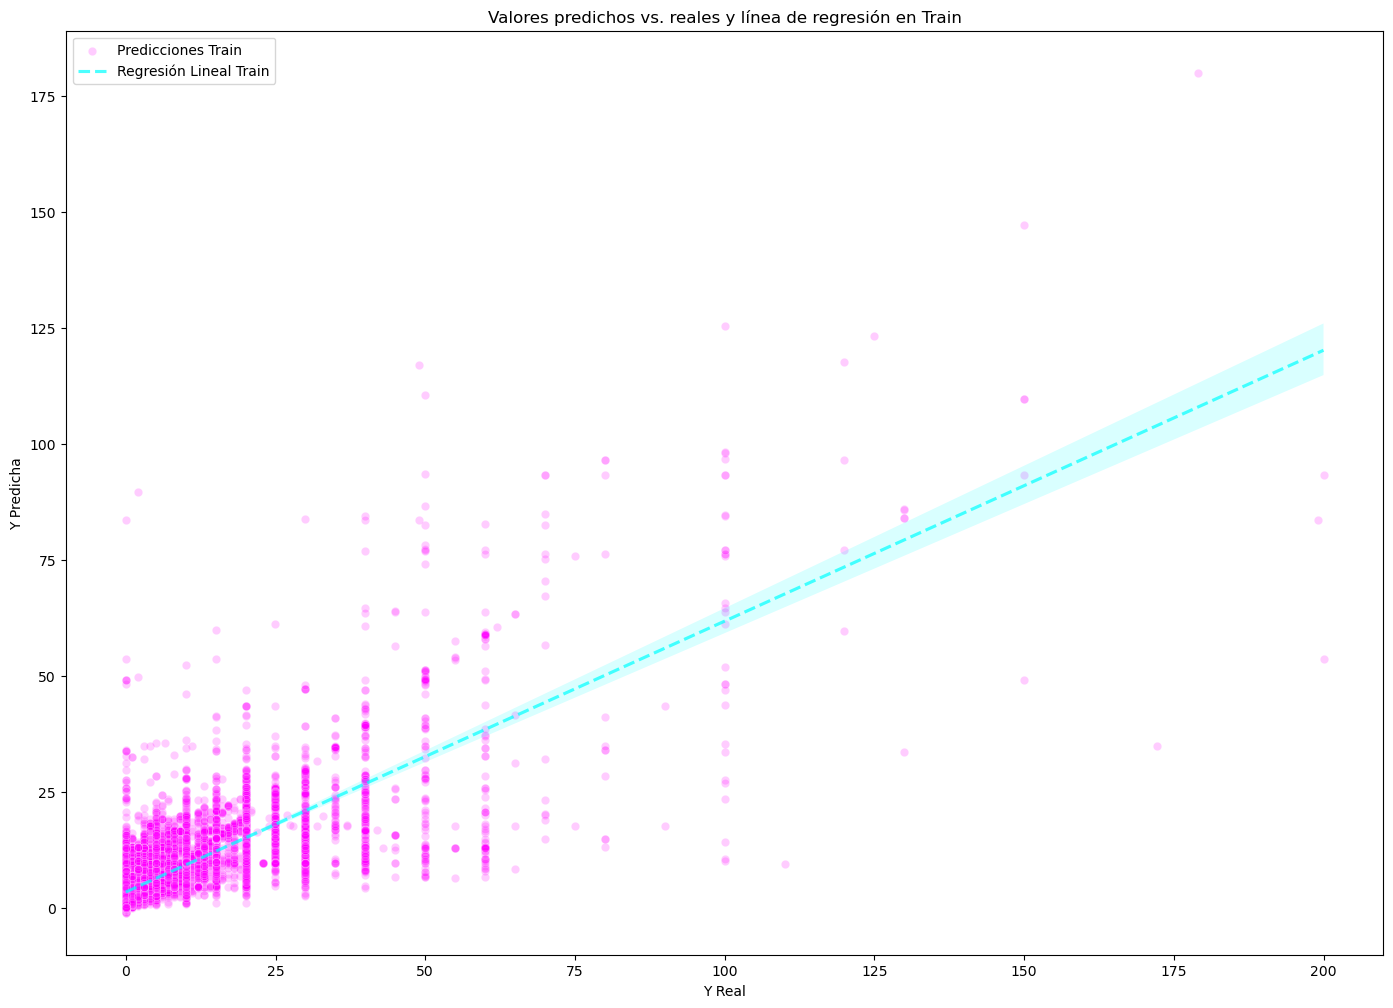

In [11]:
plt.figure(figsize=(17, 12))

sns.scatterplot(x=y_train, y=y_train_pred, label='Predicciones Train', color='magenta', alpha=0.2)

sns.regplot(x=y_train, y=y_train_pred, label='Regresión Lineal Train', scatter=False, color='cyan', line_kws={'linestyle': '--', 'alpha': 0.7})


plt.xlabel('Y Real')
plt.ylabel('Y Predicha')
plt.title('Valores predichos vs. reales y línea de regresión en Train')

plt.legend()

plt.show()

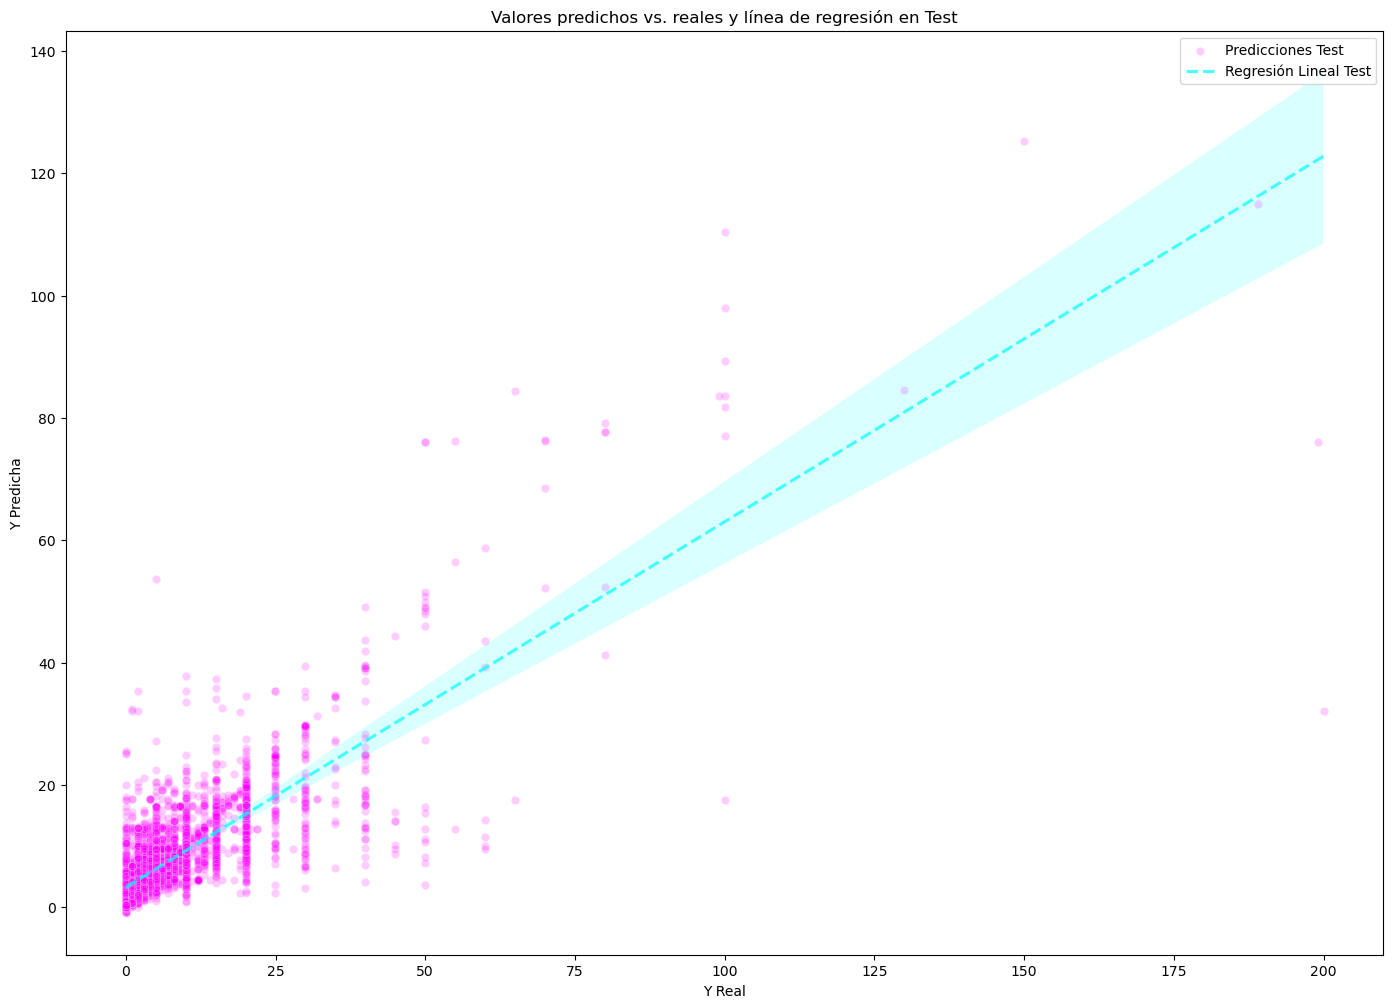

In [12]:
plt.figure(figsize=(17, 12))

sns.scatterplot(x=y_test, y=y_test_pred, label='Predicciones Test', color='magenta', alpha=0.2)

sns.regplot(x=y_test, y=y_test_pred, label='Regresión Lineal Test', scatter=False, color='cyan', line_kws={'linestyle': '--', 'alpha': 0.7})

plt.xlabel('Y Real')
plt.ylabel('Y Predicha')
plt.title('Valores predichos vs. reales y línea de regresión en Test')

plt.legend()

plt.show()

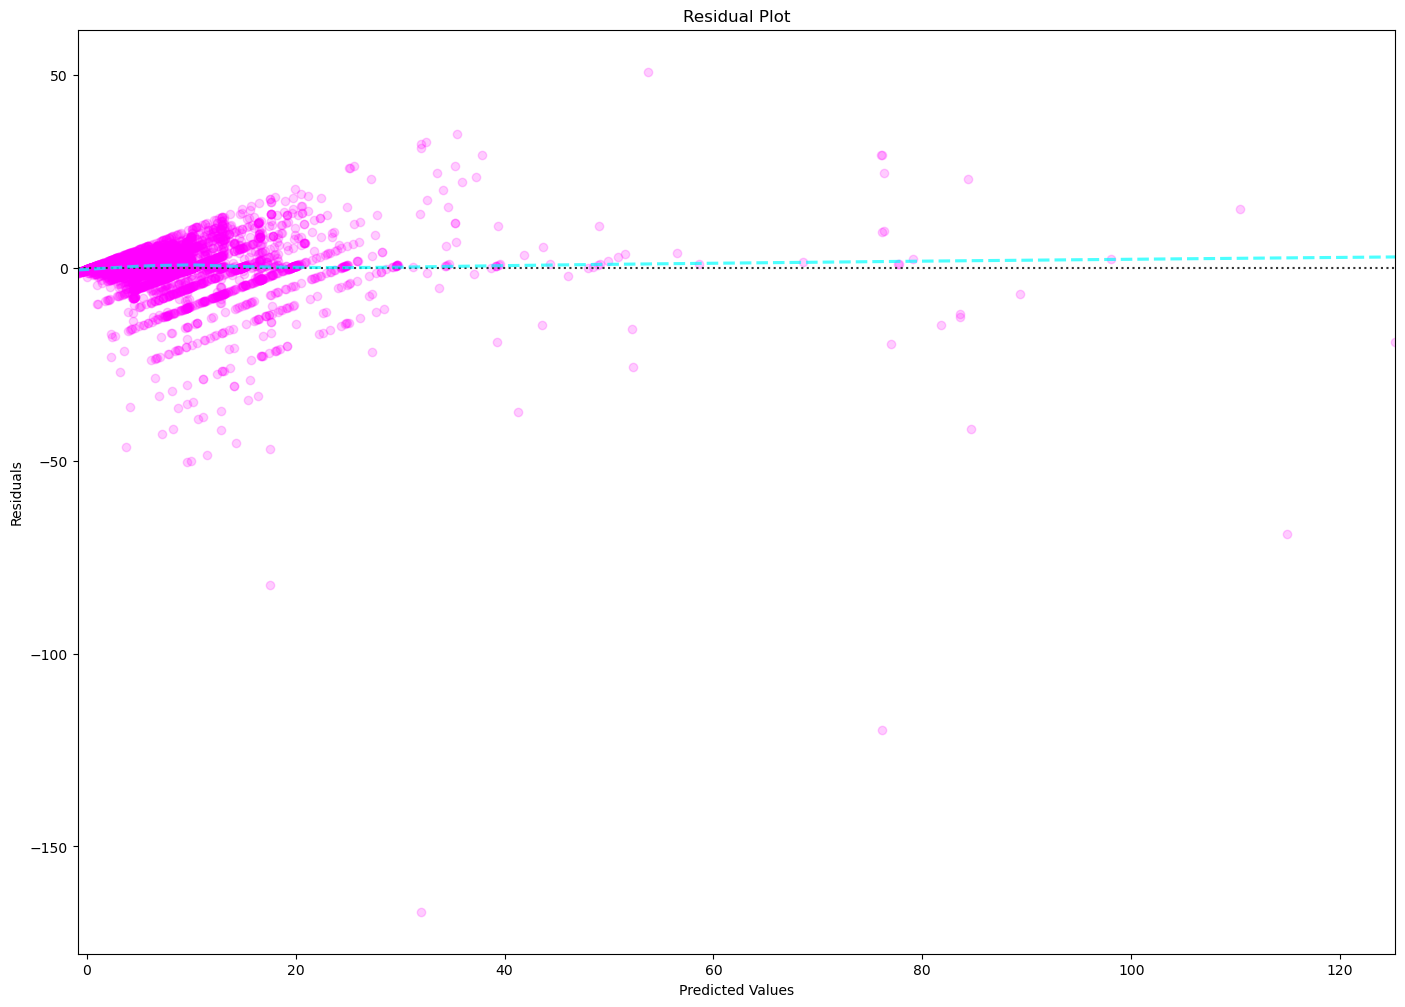

In [13]:
plt.figure(figsize=(17, 12))
sns.residplot(x=y_test_pred, y=y_test_pred - y_test, lowess=True, color='magenta',
              scatter_kws={'alpha': 0.2}, line_kws={'color': 'cyan', 'linestyle': '--', 'alpha': 0.7})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


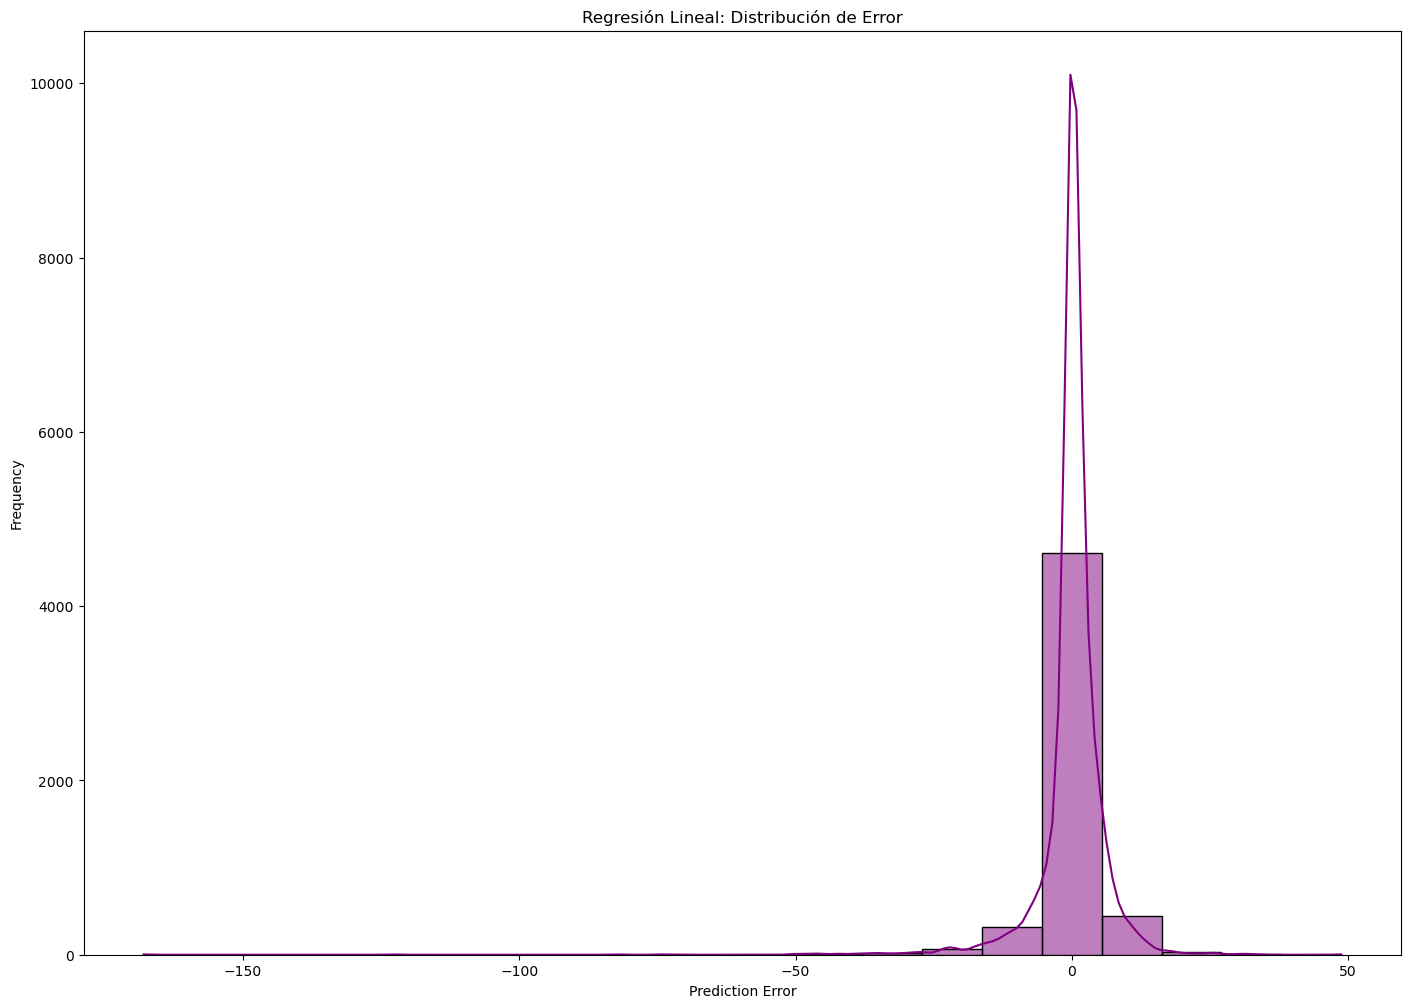

In [14]:
plt.figure(figsize=(17, 12))
sns.histplot(y_test_pred - y_test, bins=20, kde=True, color='purple')
plt.title('Regresión Lineal: Distribución de Error')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


En todos los modelos subsiguientes repetimos los pasos de instanciamiento, ajuste, y observación de métricas para evaluar el rendimiento de los mismos; así como gráficos mostrando el rendimiento y otras características del modelo.

### Modelo Lineal con características polinomiales

In [15]:
# Para este modelos vamos a aplicar dos pre procesamientos, por lo que vamos a instanciar StandardScaler nuevamente.

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_unscaled)
X_test_poly = poly.transform(X_test_unscaled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

lineal_poly = LinearRegression()
lineal_poly.fit(X_train_scaled, y_train)

LinearRegression()

Probé con 2, 3, 4. El elegido fue 2, ya en 3 los valores no tenían lógica (y 4 nunca terminó de ejecutar)

In [16]:
y_poly_train_pred = lineal_poly.predict(X_train_scaled)
y_poly_test_pred = lineal_poly.predict(X_test_scaled)

mse_train_lineal_poly = mean_squared_error(y_train, y_poly_train_pred, squared = True)
mse_test_lineal_poly = mean_squared_error(y_test, y_poly_test_pred, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_lineal_poly}')
print(f'El error cuadrático medio en Test: {mse_test_lineal_poly}')
print()
rmse_train_lineal_poly = np.sqrt(mse_train_lineal_poly)
rmse_test_lineal_poly = np.sqrt(mse_test_lineal_poly)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_lineal_poly}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_lineal_poly}')
print()
r2_lineal_poly = r2_score(y_test, y_poly_test_pred)
print('El coeficiente de determinación del regresor es:', r2_lineal_poly)

El error cuadrático medio en Train: 44.291558478833295
El error cuadrático medio en Test: 43.74634165036271

Raíz del error cuadrático medio en Train: 6.655190341292523
Raíz del error cuadrático medio en Test: 6.6141017266415485

El coeficiente de determinación del regresor es: 0.6032556359375701


Observo la cross validation

In [17]:
scores = cross_val_score(lineal_poly, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())


Cross-Validation Scores: [55.01530505 49.27337814 51.25674712 49.04225299 38.32895284 38.71371847
 48.76944788 48.53866533 45.12191974 39.231885  ]
Average MSE: 46.32922725624677


In [18]:
scores = cross_val_score(lineal_poly, X_test, y_test, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())

Cross-Validation Scores: [40.45408127 34.85426217 34.23747877 83.6309158  59.95988585 27.20760741
 34.04033958 43.84208035 37.8010061  23.99556577]
Average MSE: 42.002322306978876


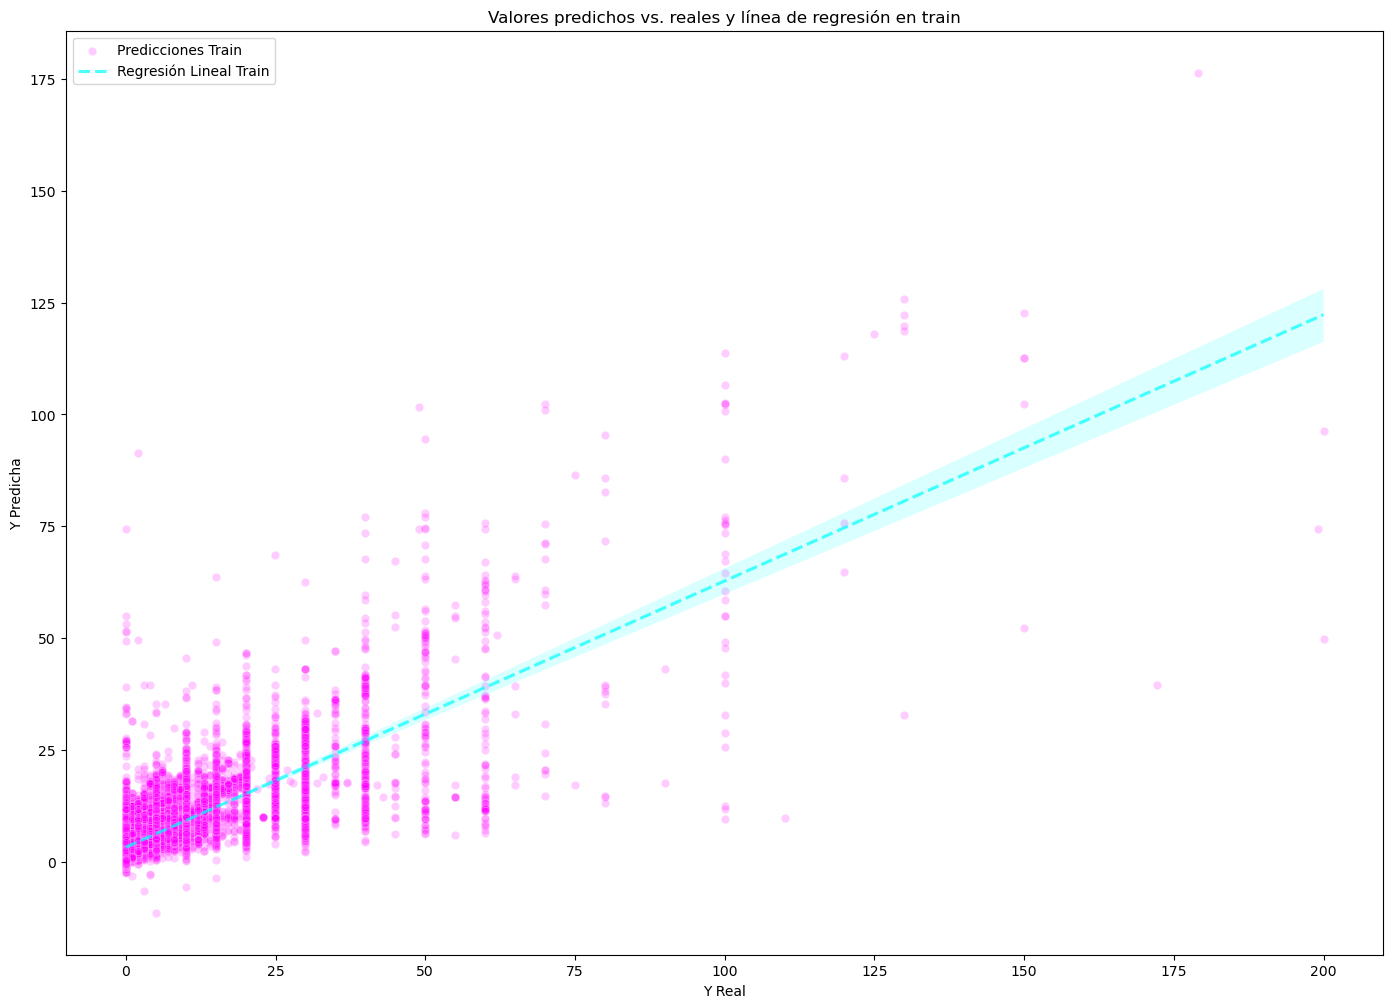

In [19]:
plt.figure(figsize=(17, 12))

sns.scatterplot(x=y_train, y=y_poly_train_pred, label='Predicciones Train', color='magenta', alpha=0.2)

sns.regplot(x=y_train, y=y_poly_train_pred, label='Regresión Lineal Train', scatter=False, color='cyan', line_kws={'linestyle': '--', 'alpha': 0.7})

plt.xlabel('Y Real')
plt.ylabel('Y Predicha')
plt.title('Valores predichos vs. reales y línea de regresión en train')

plt.legend()

plt.show()

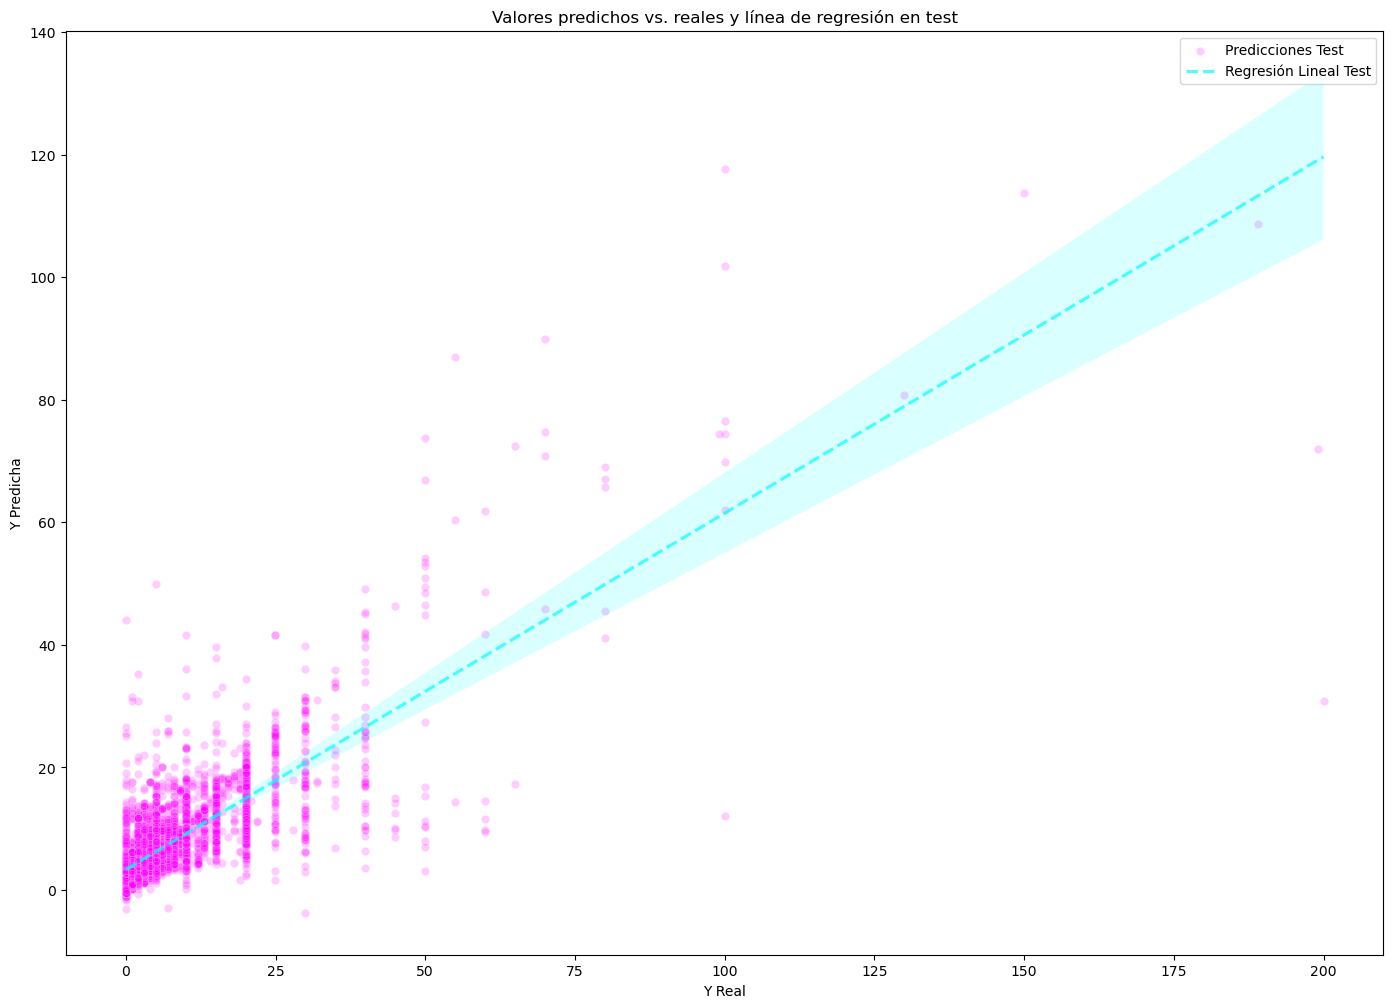

In [20]:
plt.figure(figsize=(17, 12))

sns.scatterplot(x=y_test, y=y_poly_test_pred, label='Predicciones Test', color='magenta', alpha=0.2)

sns.regplot(x=y_test, y=y_poly_test_pred, label='Regresión Lineal Test', scatter=False, color='cyan', line_kws={'linestyle': '--', 'alpha': 0.7})

plt.xlabel('Y Real')
plt.ylabel('Y Predicha')
plt.title('Valores predichos vs. reales y línea de regresión en test')

plt.legend()

plt.show()

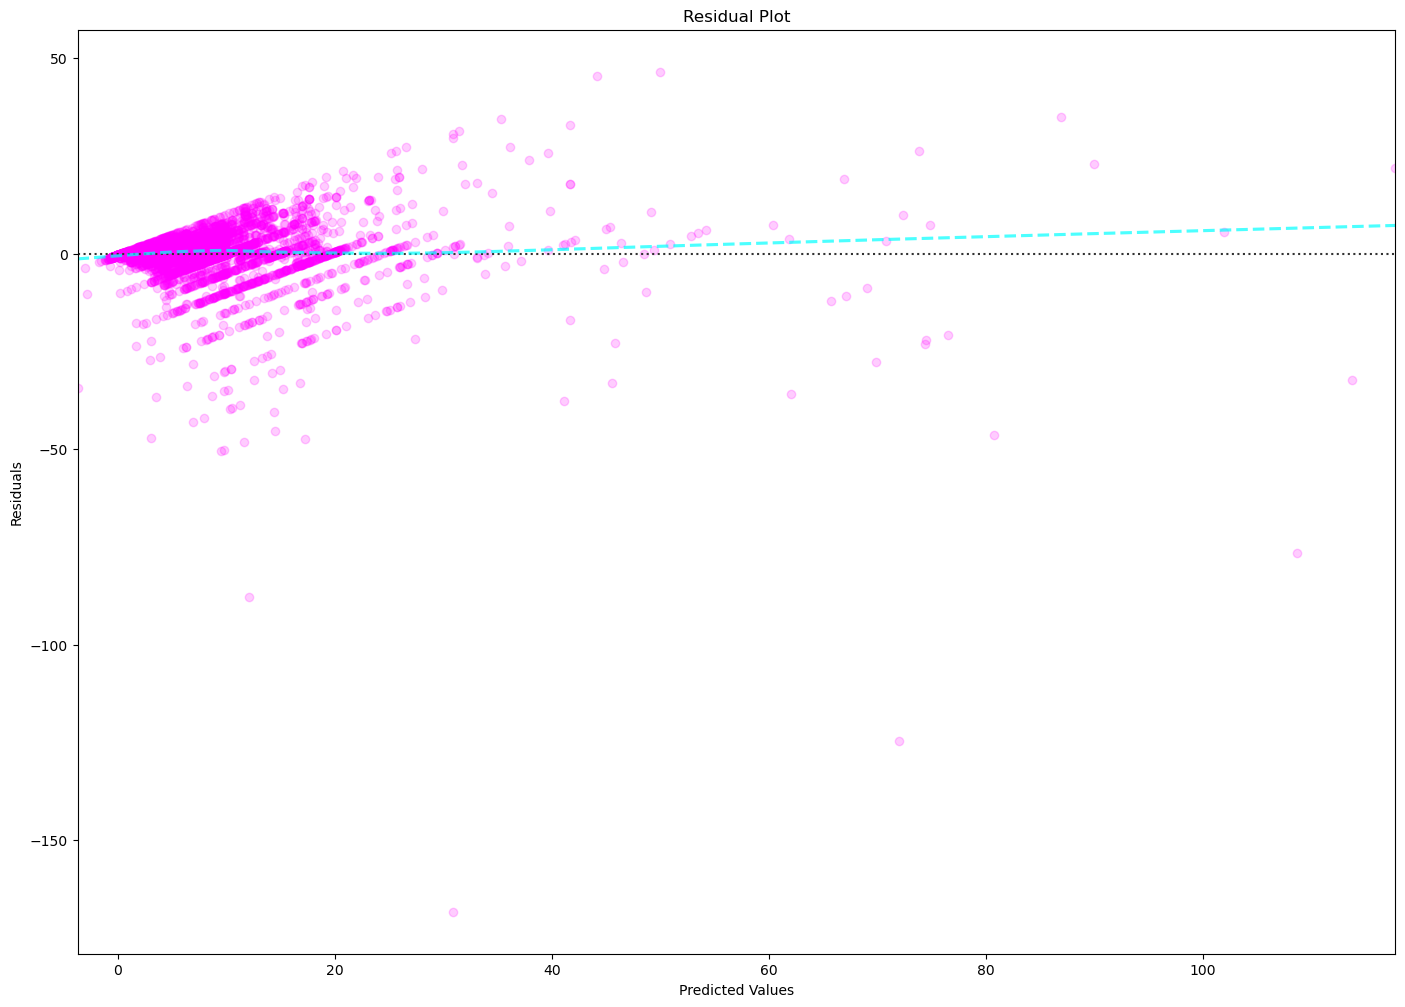

In [21]:
plt.figure(figsize=(17, 12))
sns.residplot(x=y_poly_test_pred, y=y_poly_test_pred - y_test, lowess=True, color='magenta',
              scatter_kws={'alpha': 0.2}, line_kws={'color': 'cyan', 'linestyle': '--', 'alpha': 0.7})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

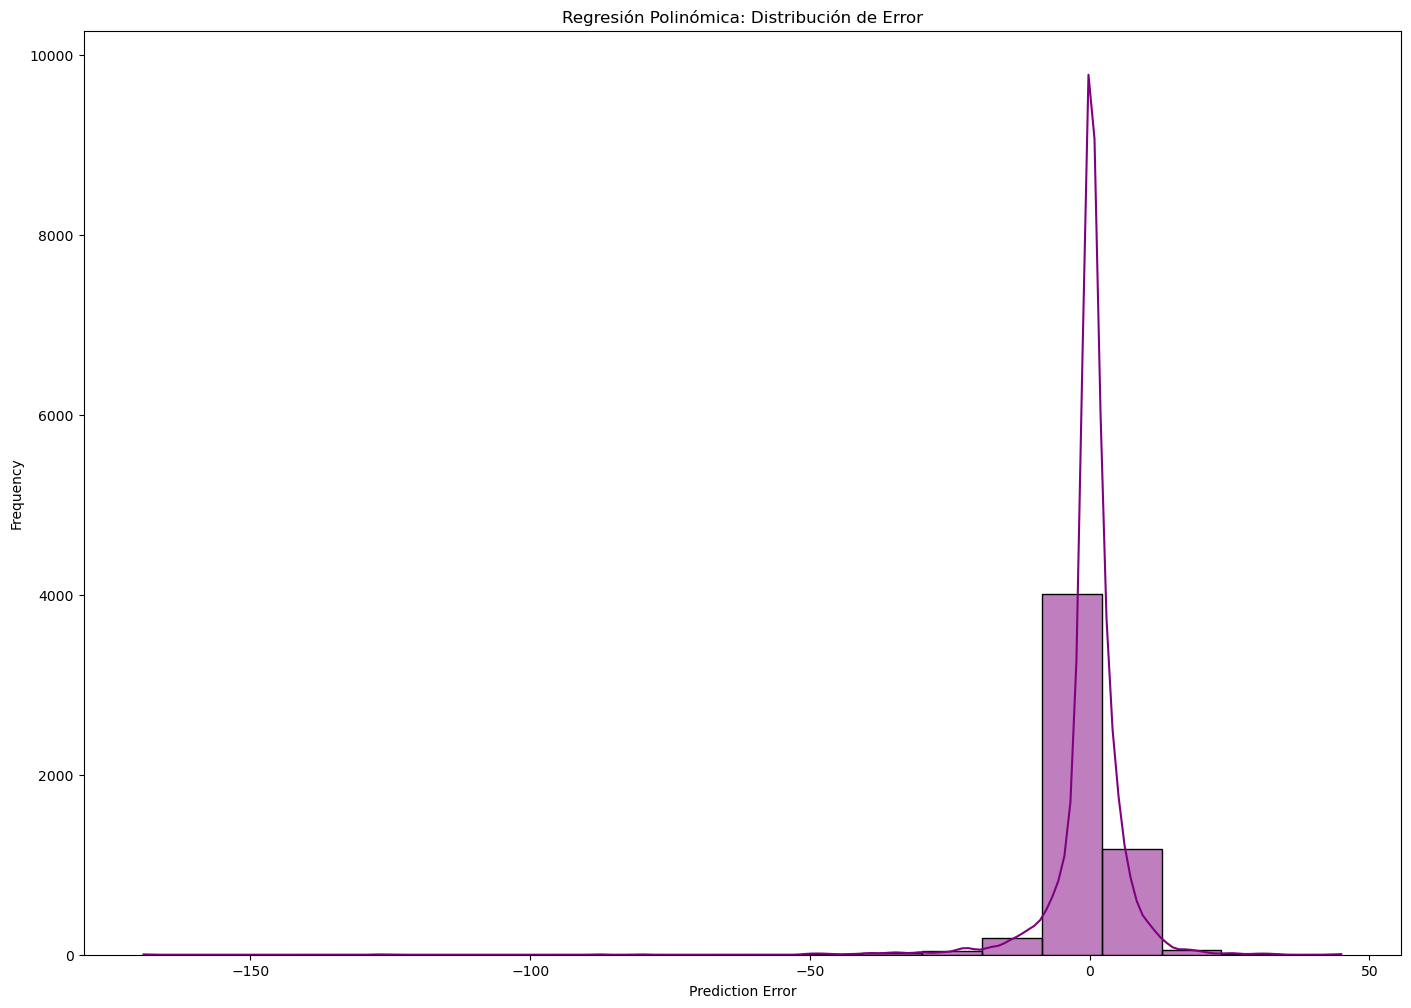

In [22]:
plt.figure(figsize=(17, 12))
sns.histplot(y_poly_test_pred - y_test, bins=20, kde=True, color='purple')
plt.title('Regresión Polinómica: Distribución de Error')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

### Modelo de Árbol (Tree)

Exploramos profundidades

In [23]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,10,1)
i = 0
i_max = len(profundidades)
for profundidad in profundidades:
    i = i + 1
    reg = DecisionTreeRegressor(max_depth=profundidad)
    tree_scores = cross_validate(reg, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Graficamos

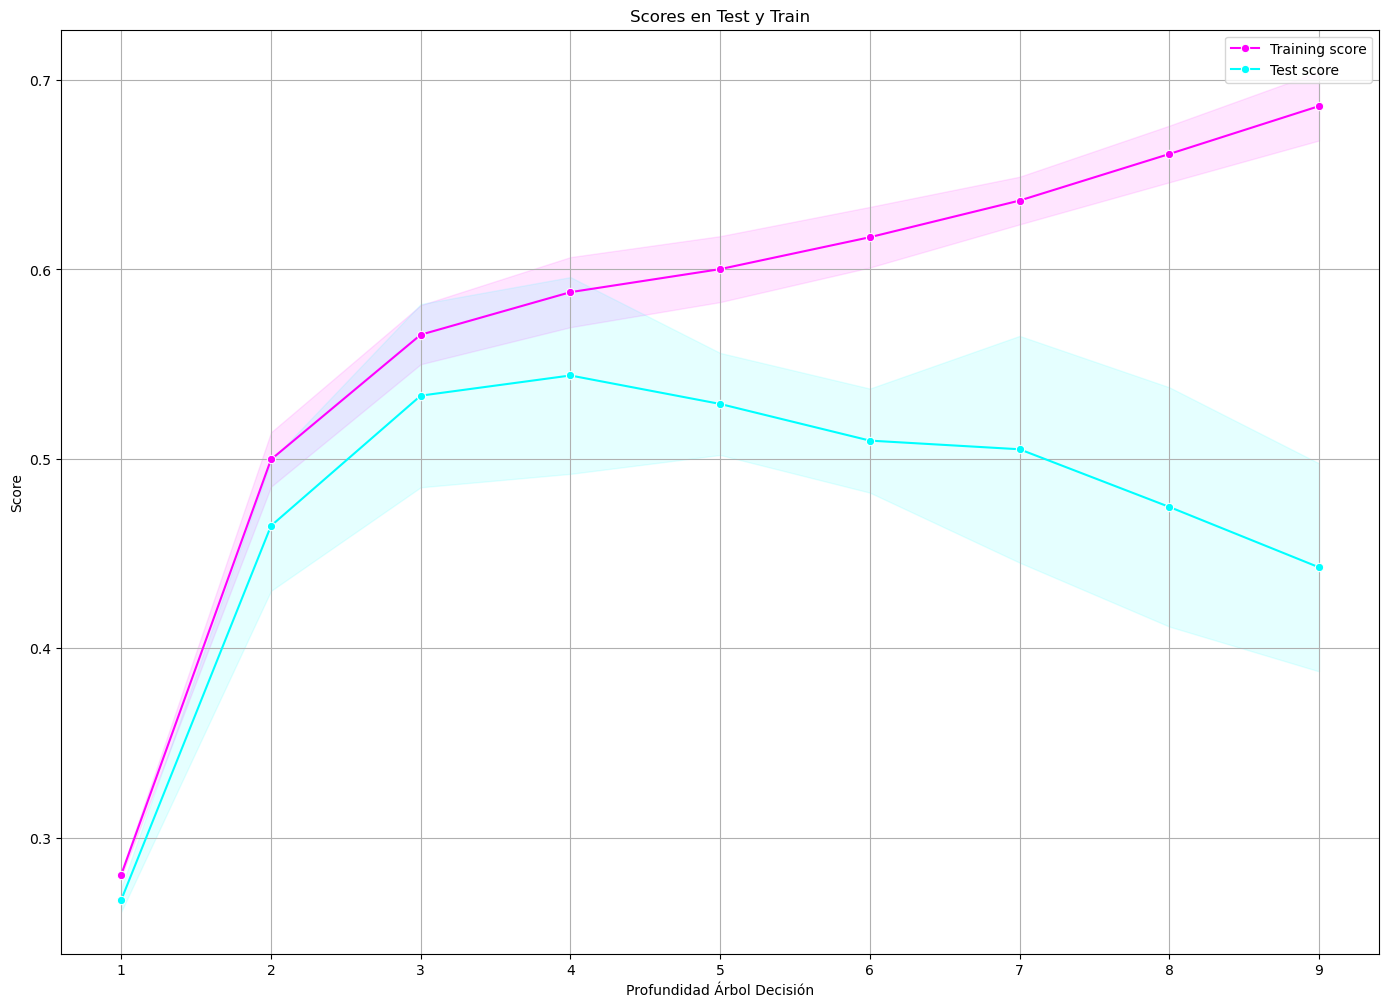

In [24]:
plt.figure(figsize=(17, 12))

sns.lineplot(x=profundidades, y=tree_train_scores_mean, marker='o', color='magenta', label='Training score')
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1, color="magenta")

sns.lineplot(x=profundidades, y=tree_test_scores_mean, marker='o', color='cyan', label='Test score')
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="cyan")

plt.legend()
plt.ylabel('Score')
plt.xlabel('Profundidad Árbol Decisión')
plt.title('Scores en Test y Train')
plt.grid(True)
plt.show()

Nos quedamos con 4, que es donde tenemos mejor rendimiento en test antes de que test y train comiencen a alejarse

In [25]:
tree = DecisionTreeRegressor(max_depth=4)

tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [26]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

mse_train_tree = mean_squared_error(y_train, y_train_pred_tree, squared = True)
mse_test_tree = mean_squared_error(y_test, y_test_pred_tree, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_tree}')
print(f'El error cuadrático medio en Test: {mse_test_tree}')
print()
rmse_train_tree = np.sqrt(mse_train_tree)
rmse_test_tree = np.sqrt(mse_test_tree)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_tree}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_tree}')
print()
r2_tree = r2_score(y_test, y_test_pred_tree)
print('El coeficiente de determinación del regresor es:', r2_tree)

El error cuadrático medio en Train: 46.32458027250495
El error cuadrático medio en Test: 44.023883813981136

Raíz del error cuadrático medio en Train: 6.8062162963356485
Raíz del error cuadrático medio en Test: 6.635049646685482

El coeficiente de determinación del regresor es: 0.600738550278491


In [27]:
scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average RMSE:", positive_scores.mean())


Cross-Validation Scores: [58.95613286 52.32133851 56.9689951  54.80972843 41.23707996 40.84877209
 51.50298446 51.68697369 48.36647073 46.5935217 ]
Average RMSE: 50.32919975308966


In [28]:
scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average RMSE:", positive_scores.mean())


Cross-Validation Scores: [54.97123984 55.65346601 40.85433183 51.77331357 45.68092824]
Average RMSE: 49.78665589676881


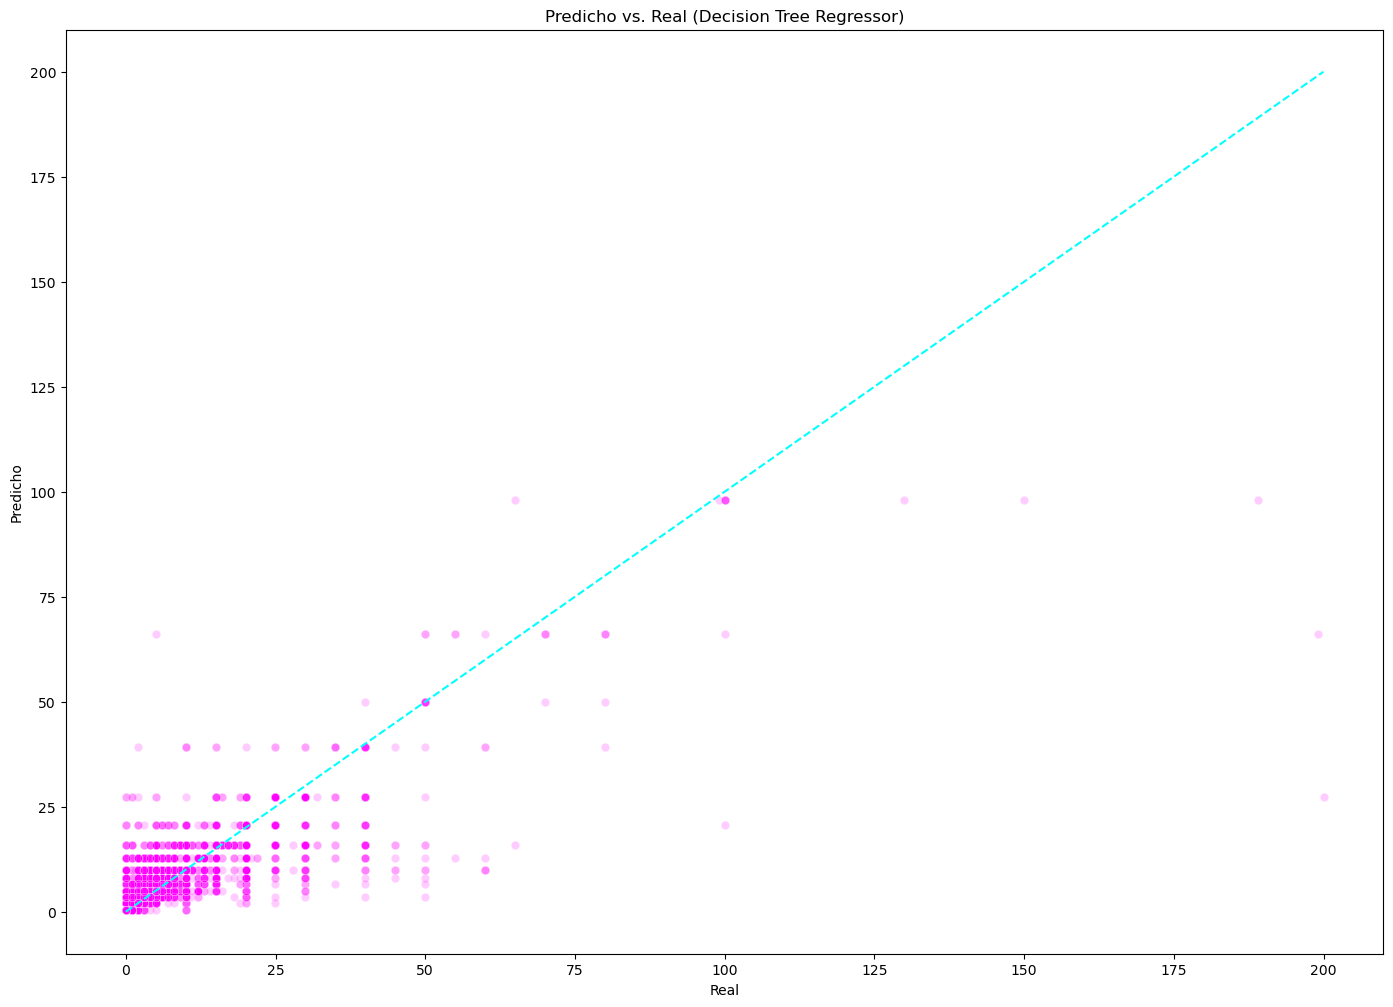

In [29]:
# Creamos un DataFrame para plottear
pred_vs_actual_tree = pd.DataFrame({'Real': y_test, 'Predicho': y_test_pred_tree})

plt.figure(figsize=(17, 12))
sns.scatterplot(x='Real', y='Predicho', data=pred_vs_actual_tree, color='magenta', alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='cyan', linestyle='--')
plt.title('Predicho vs. Real (Decision Tree Regressor)')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.show()


Observamos los valores con un residual plot

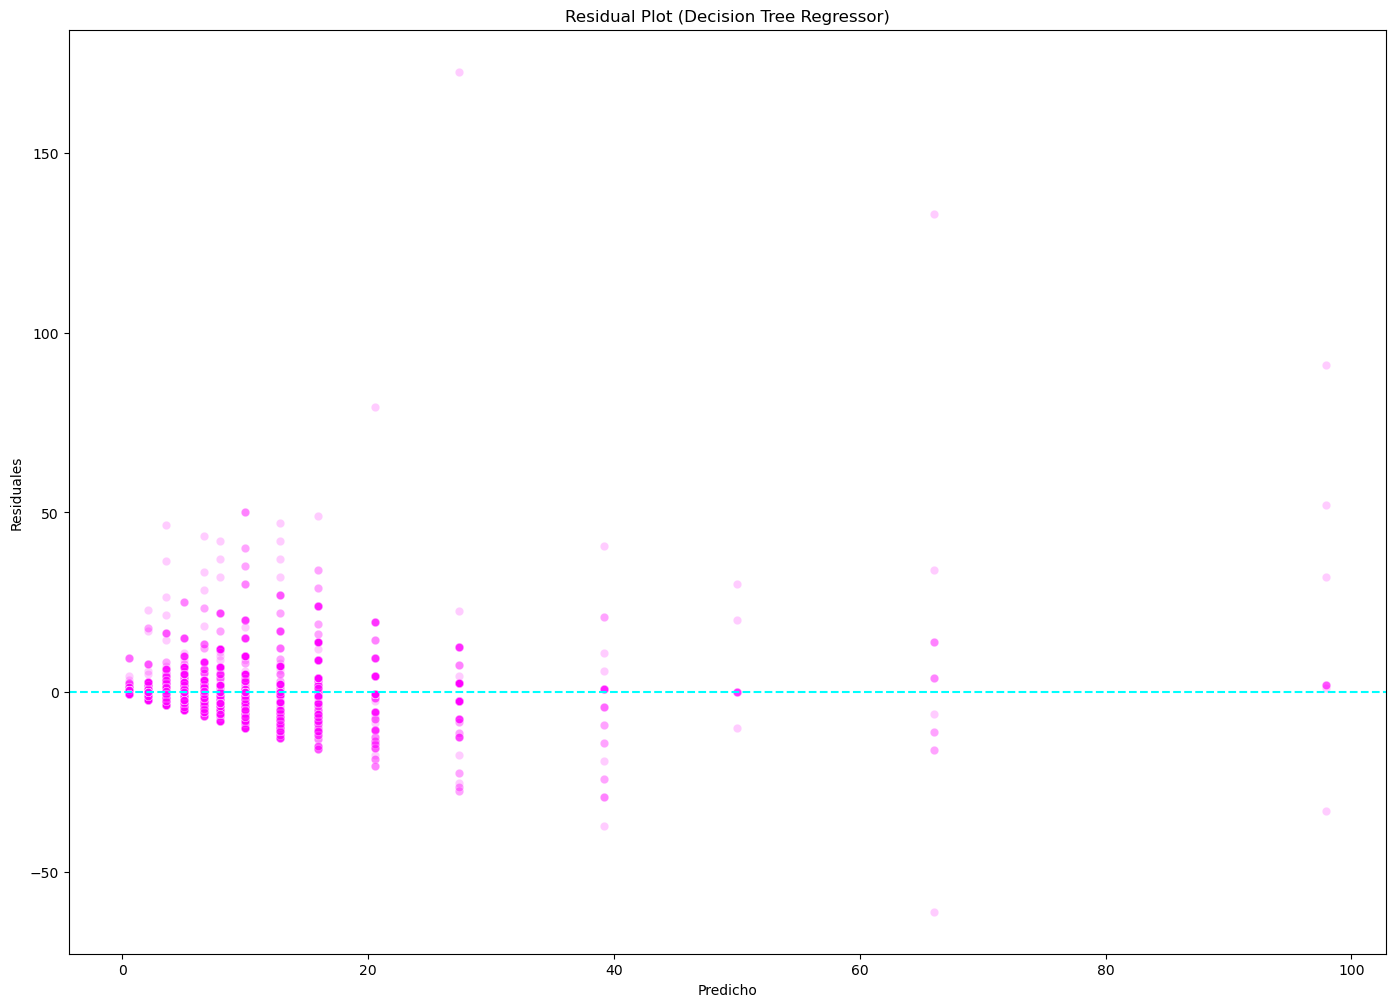

In [30]:
# Calculamos residuales
residuals_tree = y_test - y_test_pred_tree

# Armamos dataframe
residuals_df_tree = pd.DataFrame({'Residuals': residuals_tree})

# Plotteamos
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_test_pred_tree, y=residuals_tree, color='magenta', alpha=0.2)
plt.axhline(y=0, color='cyan', linestyle='--')
plt.title('Residual Plot (Decision Tree Regressor)')
plt.xlabel('Predicho')
plt.ylabel('Residuales')
plt.show()


### Modelo K-Vecinos

Observamos al curva de aprendizaje

In [31]:
k_values = [1] + list(range(5, 101, 5))
train_errors = []
test_errors = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

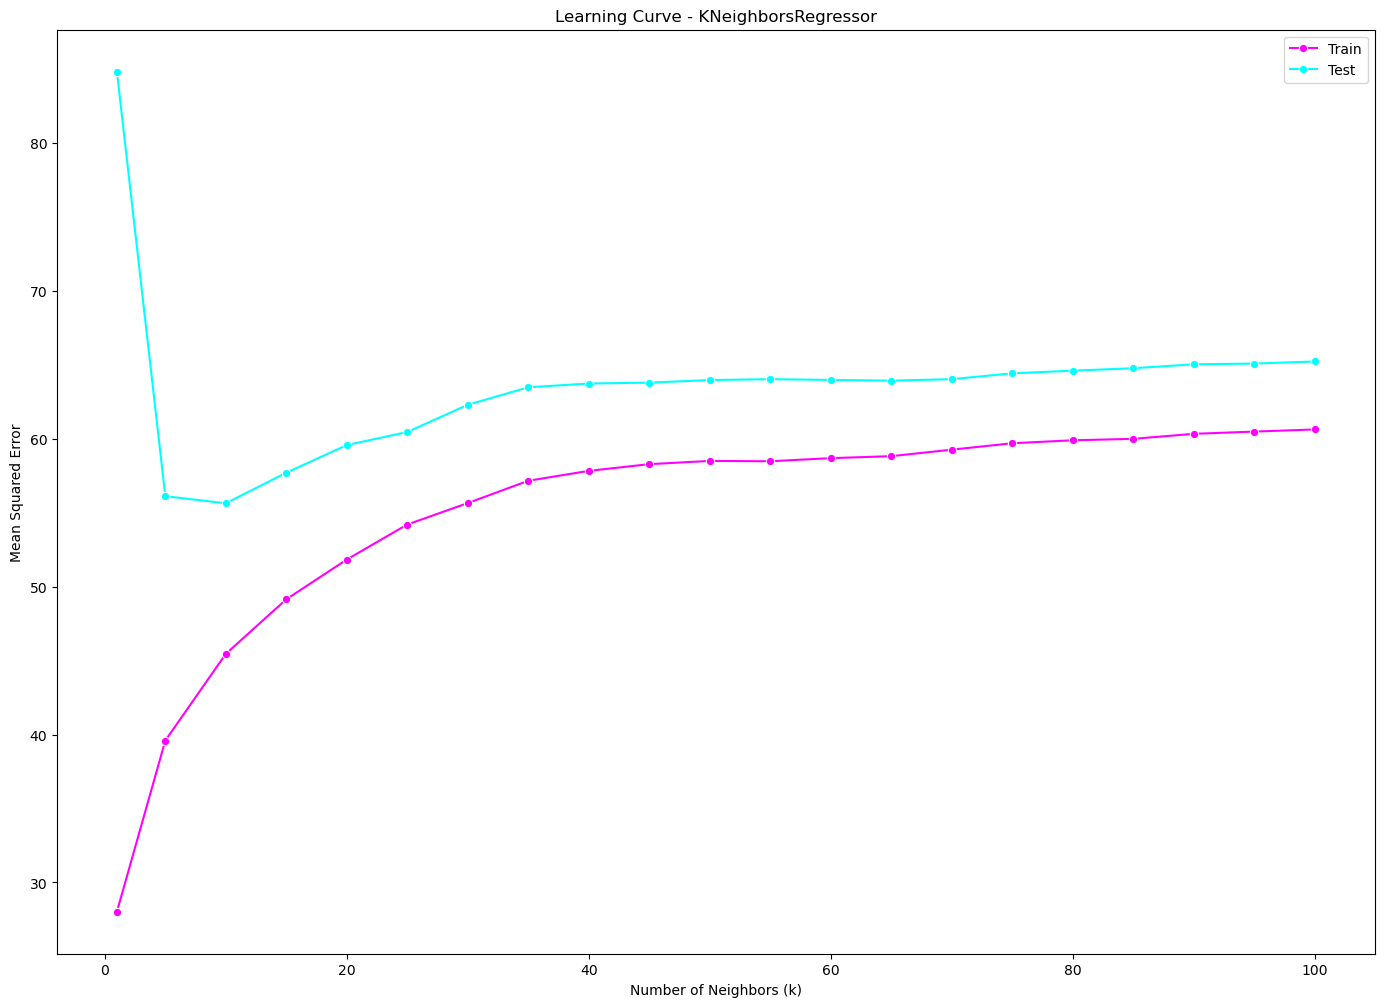

In [32]:
plt.figure(figsize=(17, 12))
sns.lineplot(x=k_values, y=train_errors, marker='o', color='magenta', label='Train')
sns.lineplot(x=k_values, y=test_errors, marker='o', color='cyan', label='Test')
plt.title('Learning Curve - KNeighborsRegressor')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


Elegimos 50, ya que en ese punto la distacia entre test y train es la menor, antes de que comience a subir el MSE.

In [33]:
neighbors =  KNeighborsRegressor(n_neighbors=50)

neighbors.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

In [34]:
y_train_pred_nei = neighbors.predict(X_train)
y_test_pred_nei = neighbors.predict(X_test)

mse_train_nei = mean_squared_error(y_train, y_train_pred_nei, squared = True)
mse_test_nei = mean_squared_error(y_test, y_test_pred_nei, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_nei}')
print(f'El error cuadrático medio en Test: {mse_test_nei}')
print()
rmse_train_nei = np.sqrt(mse_train_nei)
rmse_test_nei = np.sqrt(mse_test_nei)
print(rmse_train_nei)
print(rmse_test_nei)
print()
r2_nei = r2_score(y_test, y_test_pred_nei)
print('El coeficiente de determinación del regresor es:', r2_nei)

El error cuadrático medio en Train: 58.5056071113135
El error cuadrático medio en Test: 63.97334589556322

7.648895809939726
7.998333944988995

El coeficiente de determinación del regresor es: 0.4198128694477783


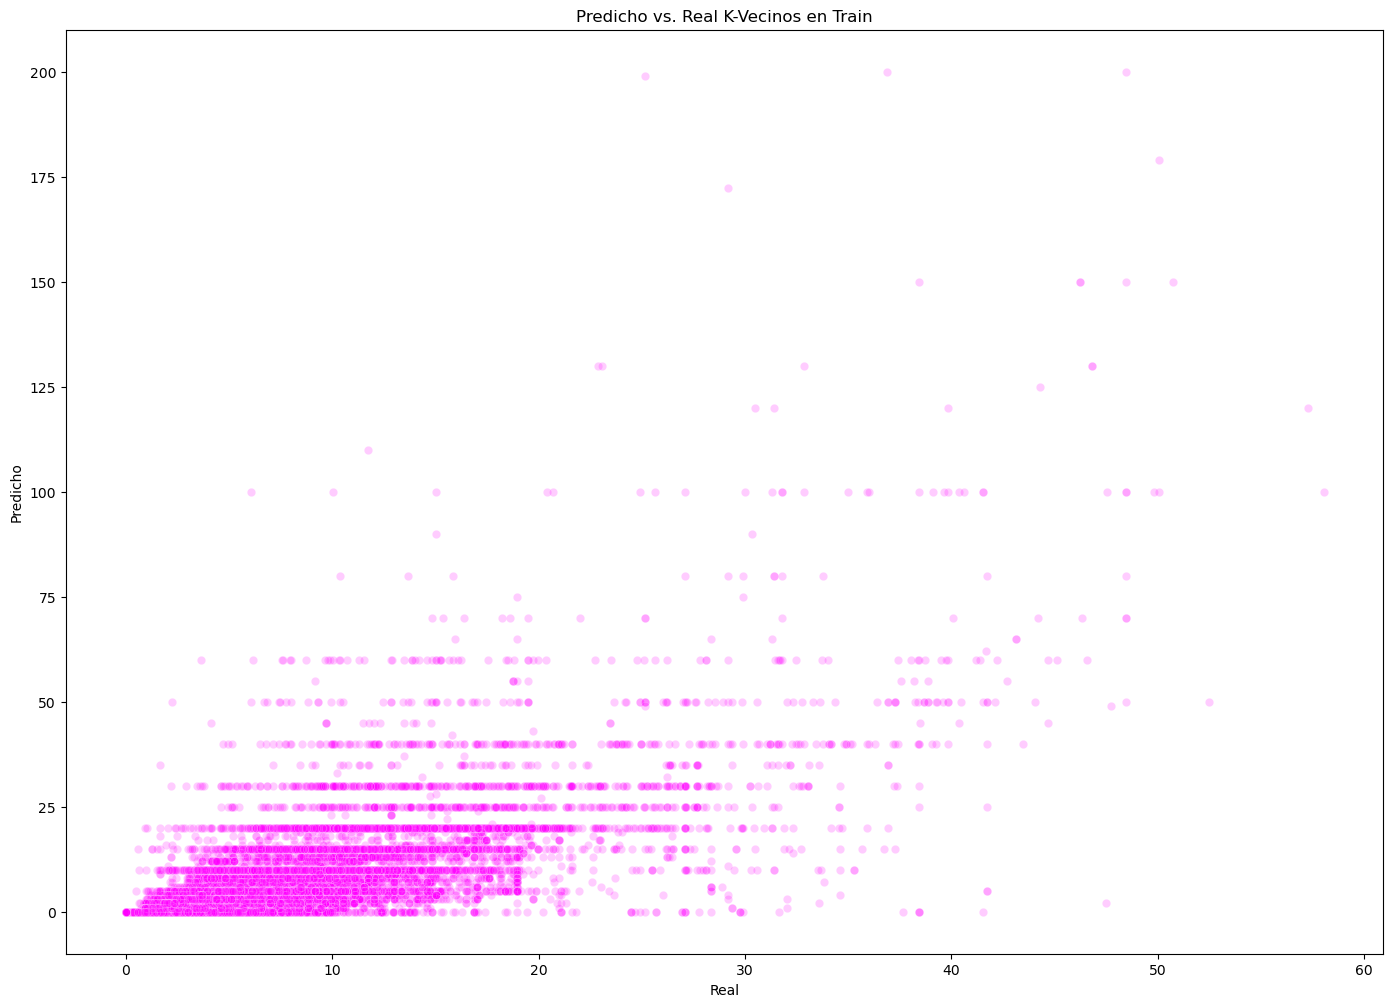

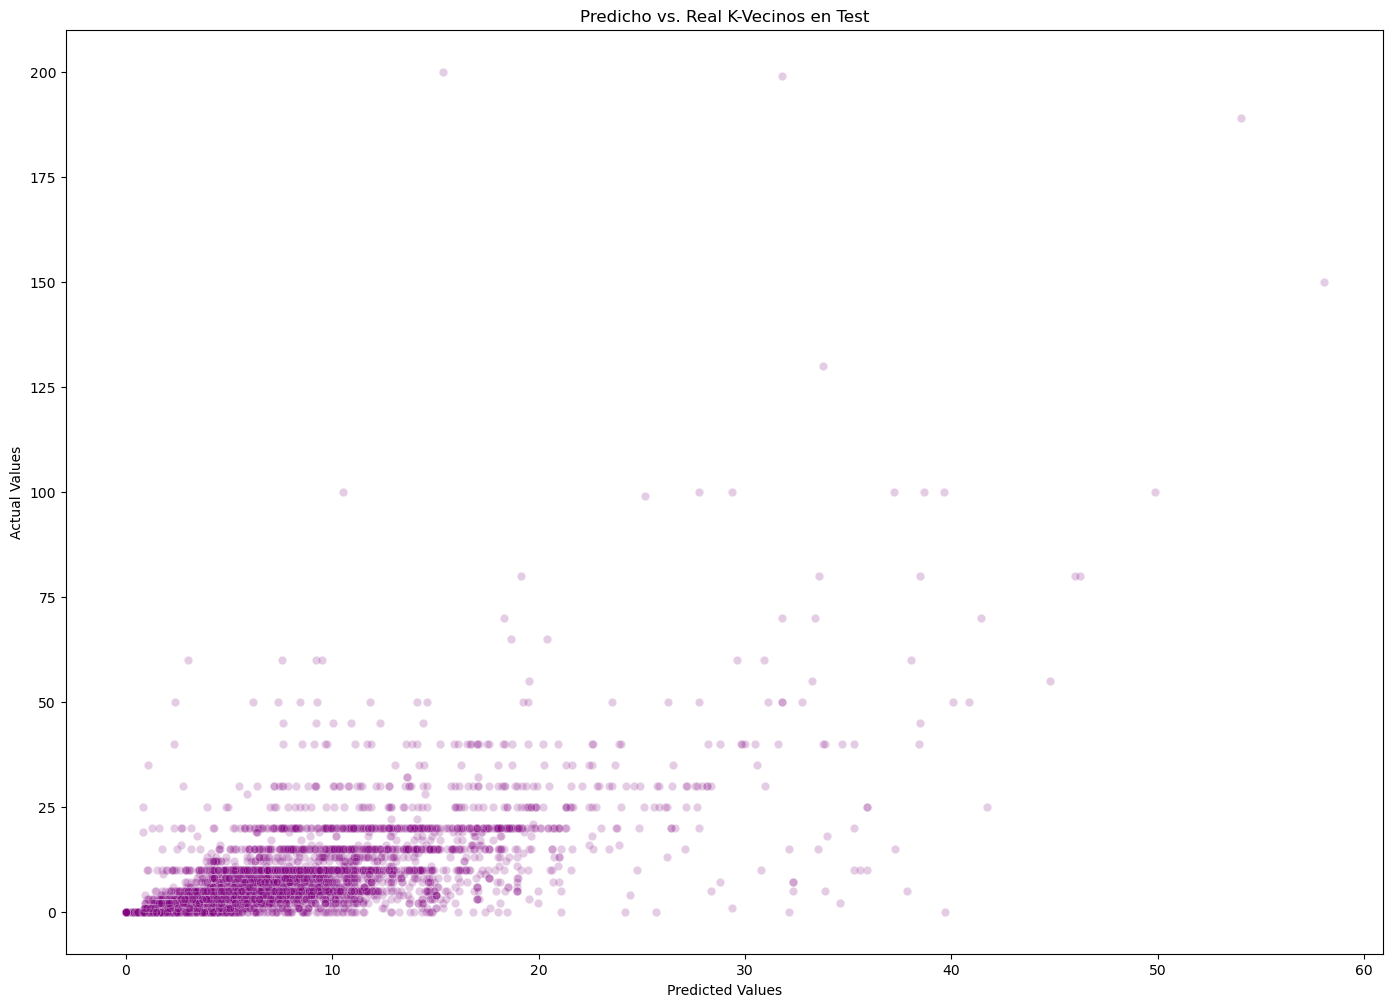

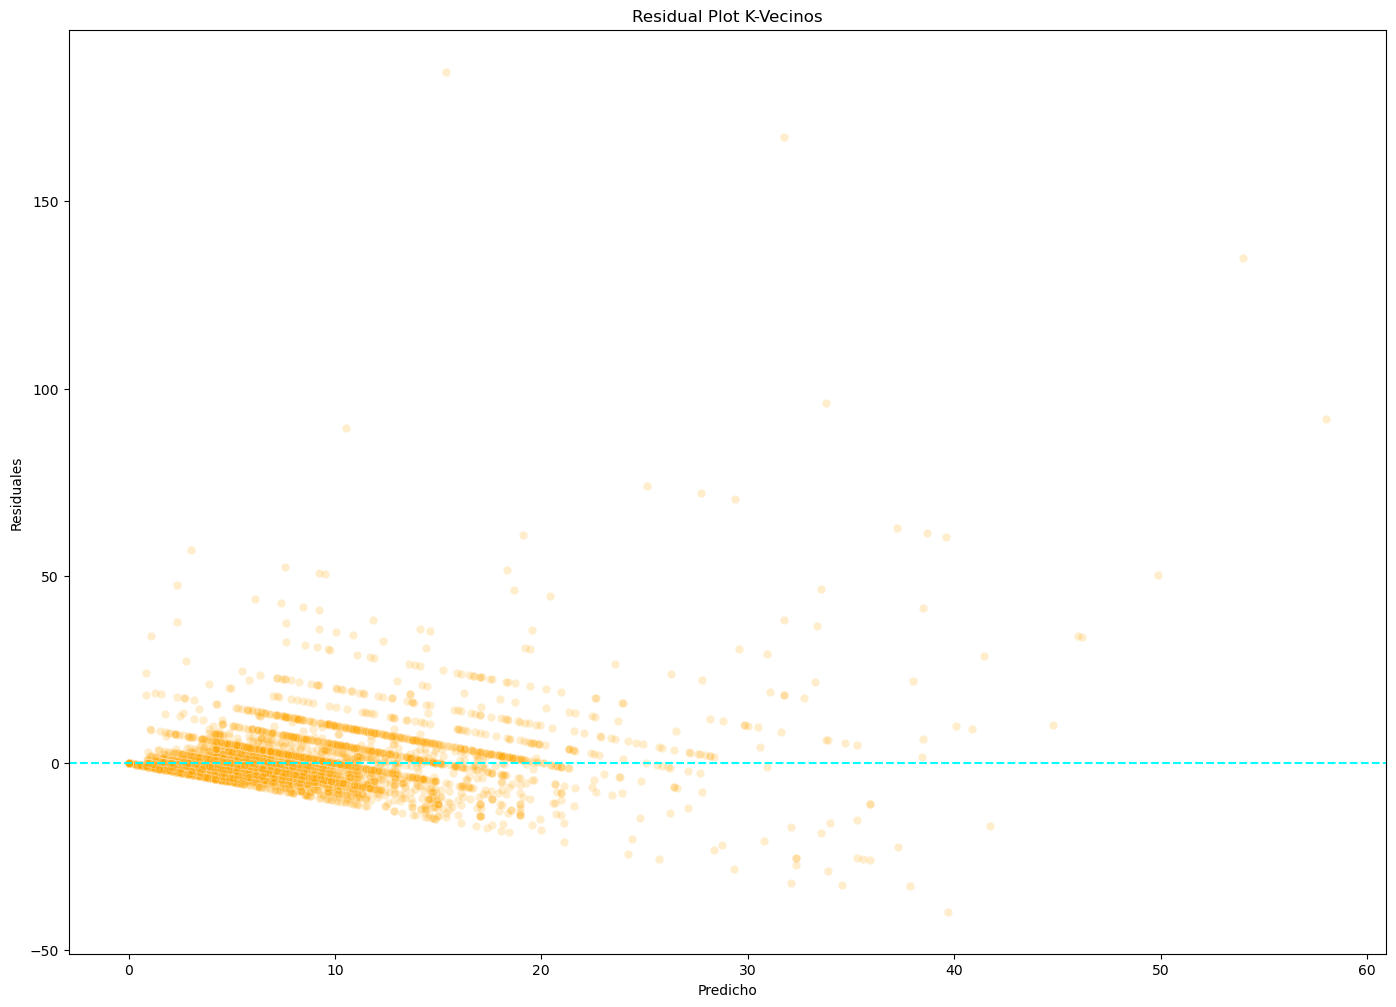

In [35]:
# Scatter plot for Predicted vs. Actual values (Train)
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_train_pred_nei, y=y_train, color='magenta', alpha=0.2)
plt.title('Predicho vs. Real K-Vecinos en Train')
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.show()

# Scatter plot for Predicted vs. Actual values (Test)
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_test_pred_nei, y=y_test, color='purple', alpha=0.2)
plt.title('Predicho vs. Real K-Vecinos en Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


# Residuales
residuals = y_test - y_test_pred_nei
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_test_pred_nei, y=residuals, color='orange', alpha=0.2)
plt.axhline(y=0, color='cyan', linestyle='--')
plt.title('Residual Plot K-Vecinos')
plt.xlabel('Predicho')
plt.ylabel('Residuales')
plt.show()

### Modelo Random Forest

Exploramos diferentes números de estimadores

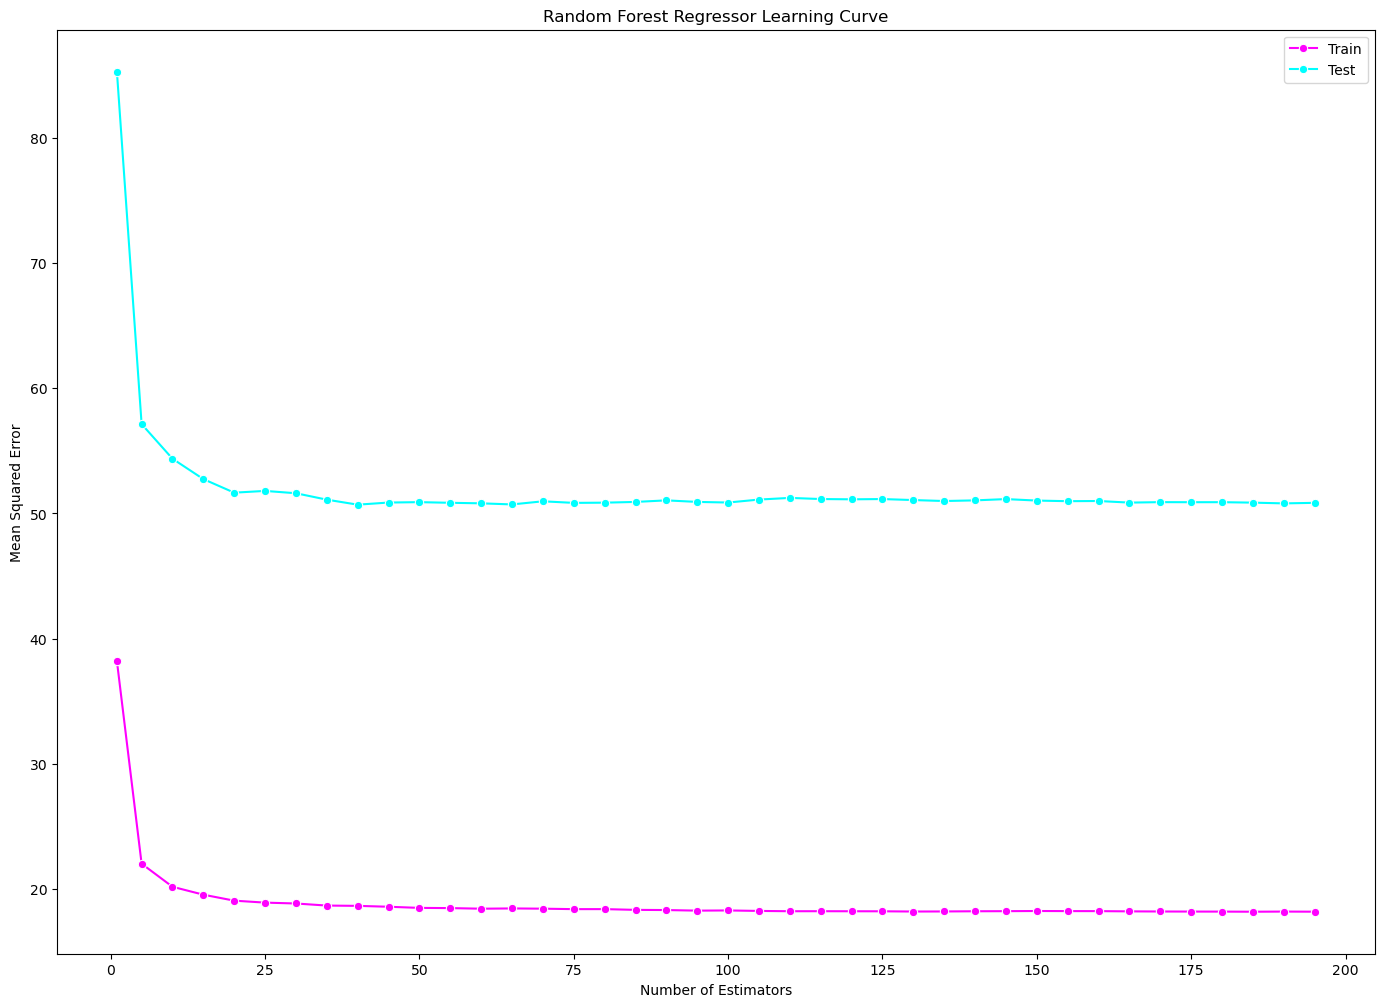

In [36]:
n_estimators = [1] + list(range(5, 200, 5))
train_errors_forest = []
test_errors_forest = []

for n in n_estimators:
    forest = RandomForestRegressor(n_estimators=n, random_state=42)
    forest.fit(X_train, y_train)
    y_train_pred_forest = forest.predict(X_train)
    y_test_pred_forest = forest.predict(X_test)
    train_errors_forest.append(mean_squared_error(y_train, y_train_pred_forest))
    test_errors_forest.append(mean_squared_error(y_test, y_test_pred_forest))

plt.figure(figsize=(17, 12))
sns.lineplot(x=n_estimators, y=train_errors_forest, marker='o', color='magenta', label='Train')
sns.lineplot(x=n_estimators, y=test_errors_forest, marker='o', color='cyan', label='Test')
plt.title('Random Forest Regressor Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


El MSE se estabiliza alrededor de 50

In [37]:
forest = RandomForestRegressor(n_estimators=50, random_state=42)

forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [38]:
y_train_pred_forest = forest.predict(X_train)
y_test_pred_forest = forest.predict(X_test)

mse_train_forest = mean_squared_error(y_train, y_train_pred_forest, squared = True)
mse_test_forest = mean_squared_error(y_test, y_test_pred_forest, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_forest}')
print(f'El error cuadrático medio en Test: {mse_test_forest}')
print()
rmse_train_forest = np.sqrt(mse_train_forest)
rmse_test_forest = np.sqrt(mse_test_forest)
print(rmse_train_forest)
print(rmse_test_forest)
print()
r2_forest = r2_score(y_test, y_test_pred_forest)
print('El coeficiente de determinación del regresor es:', r2_forest)

El error cuadrático medio en Train: 18.507695492121066
El error cuadrático medio en Test: 50.89978722922725

4.3020571232982325
7.134408681119077

El coeficiente de determinación del regresor es: 0.5383796003658441


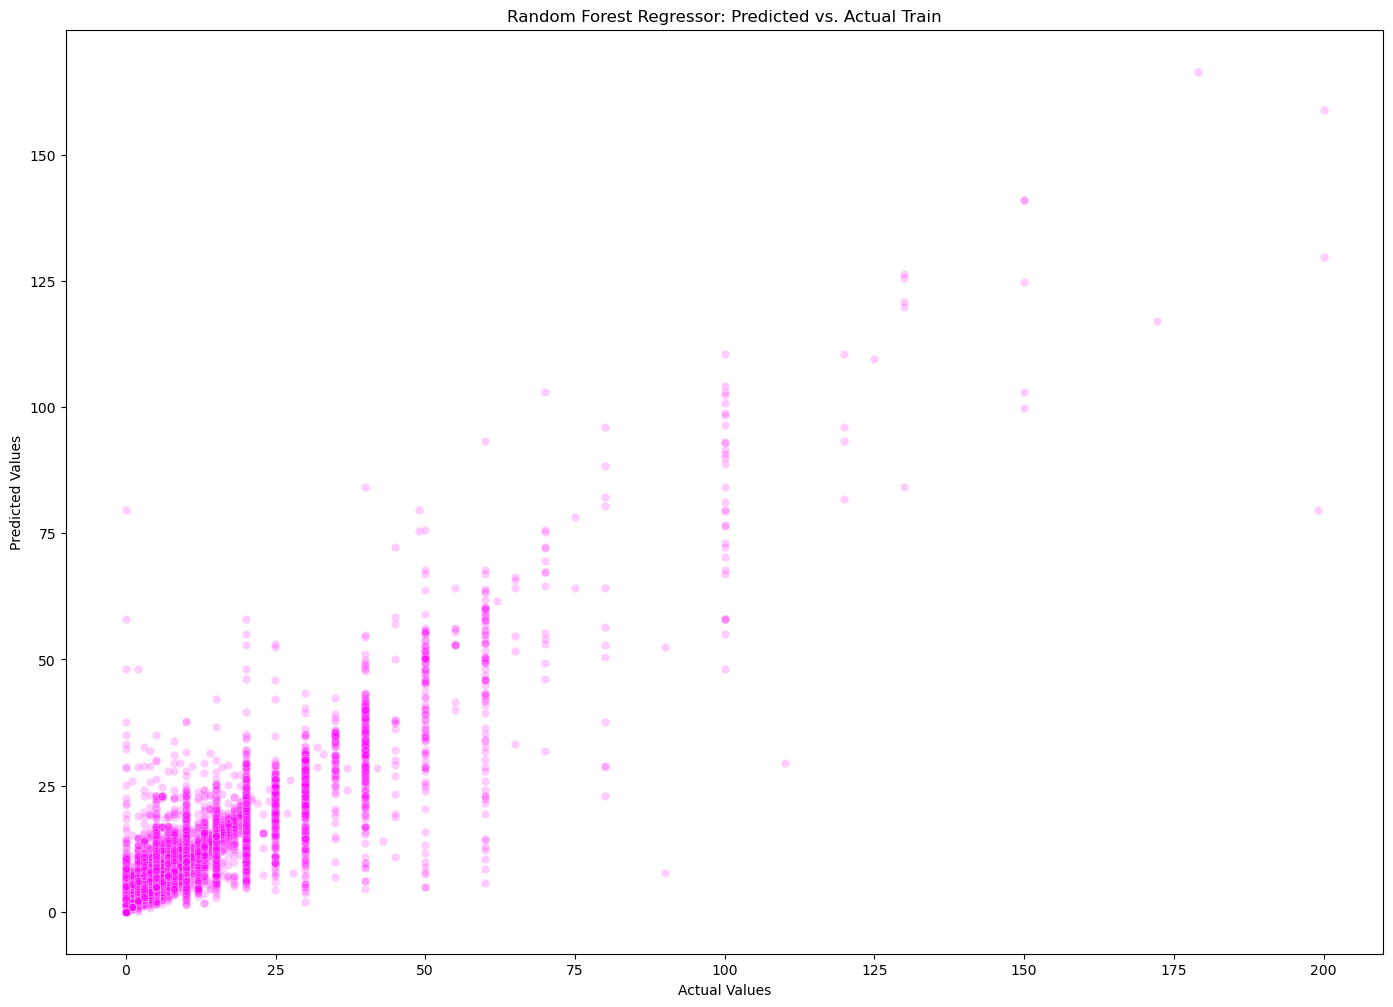

In [39]:
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_train, y=y_train_pred_forest, color='magenta', alpha=0.2)
plt.title('Random Forest Regressor: Predicted vs. Actual Train')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


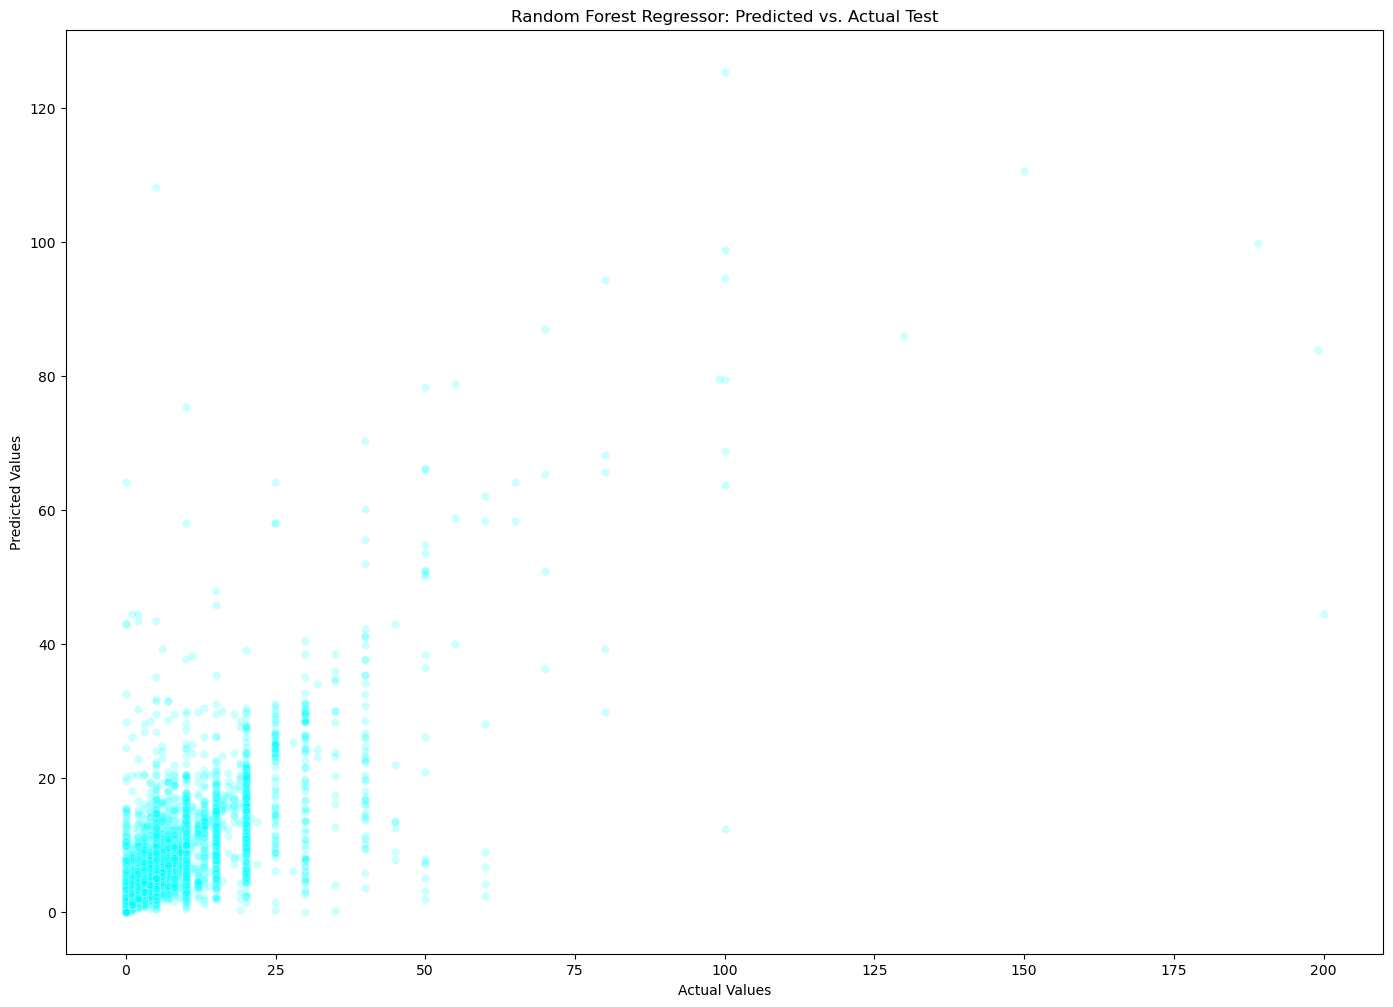

In [40]:
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_test, y=y_test_pred_forest, color='cyan', alpha=0.2)
plt.title('Random Forest Regressor: Predicted vs. Actual Test')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


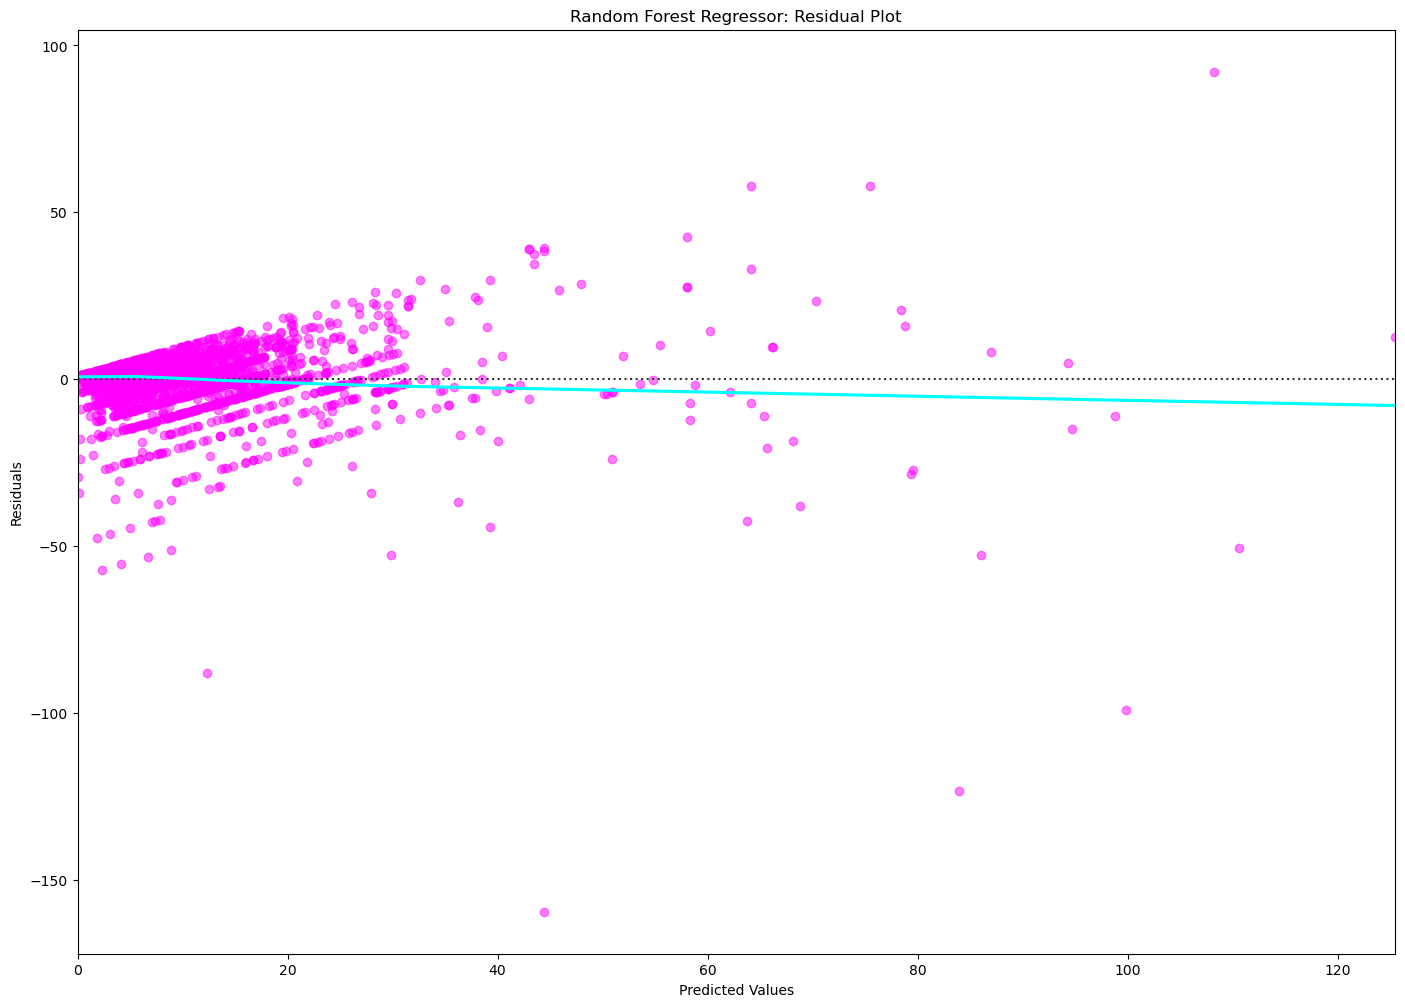

In [41]:
plt.figure(figsize=(17, 12))
sns.residplot(x=y_test_pred_forest, y=y_test_pred_forest - y_test, lowess=True, color='magenta',
              scatter_kws={'alpha': 0.5}, line_kws={'color': 'cyan'})
plt.title('Random Forest Regressor: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Modelo Support Vector

Elegimos el valor de C para la variante lineal

In [42]:
vector_test = SupportVectorRegressor(kernel='linear')

search_space = {
    'C': [0.01, 0.1, 1],
}

rsearch = GridSearchCV(
    vector_test, search_space,
    n_jobs=-1, scoring='accuracy', cv=3, verbose=0)


rsearch.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1]}, scoring='accuracy')

In [43]:
rsearch.best_params_

{'C': 0.01}

In [44]:
vector_linear = SupportVectorRegressor(kernel='linear', C=0.01)

vector_linear.fit(X_train, y_train)

SVR(C=0.01, kernel='linear')

In [45]:
y_train_pred_vector_linear = vector_linear.predict(X_train)
y_test_pred_vector_linear = vector_linear.predict(X_test)

mse_train_vector_linear = mean_squared_error(y_train, y_train_pred_vector_linear, squared = True)
mse_test_vector_linear = mean_squared_error(y_test, y_test_pred_vector_linear, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_vector_linear}')
print(f'El error cuadrático medio en Test: {mse_test_vector_linear}')
print()
rmse_train_vector_linear = np.sqrt(mse_train_vector_linear)
rmse_test_vector_linear = np.sqrt(mse_test_vector_linear)
print(rmse_train_vector_linear)
print(rmse_test_vector_linear)
print()
r2_vector_linear = r2_score(y_test, y_test_pred_vector_linear)
print('El coeficiente de determinación del regresor es:', r2_vector_linear)

El error cuadrático medio en Train: 46.14657385864588
El error cuadrático medio en Test: 41.18376195533043

6.793126957347837
6.417457592795642

El coeficiente de determinación del regresor es: 0.626496186189535


In [46]:
scores = cross_val_score(vector_linear, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average RMSE:", positive_scores.mean())

Cross-Validation Scores: [54.31873906 49.07700954 50.21982048 49.23127359 38.54643084 38.64855118
 49.02362487 48.38914542 45.2528952  39.10407251]
Average RMSE: 46.18115626827562


In [47]:
scores = cross_val_score(vector_linear, X_test, y_test, cv=10, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average RMSE:", positive_scores.mean())

Cross-Validation Scores: [44.61899451 32.85460796 34.5782174  82.56292875 62.94159716 27.25193765
 33.90339633 43.85603821 37.35818331 22.63020661]
Average RMSE: 42.25561078845983


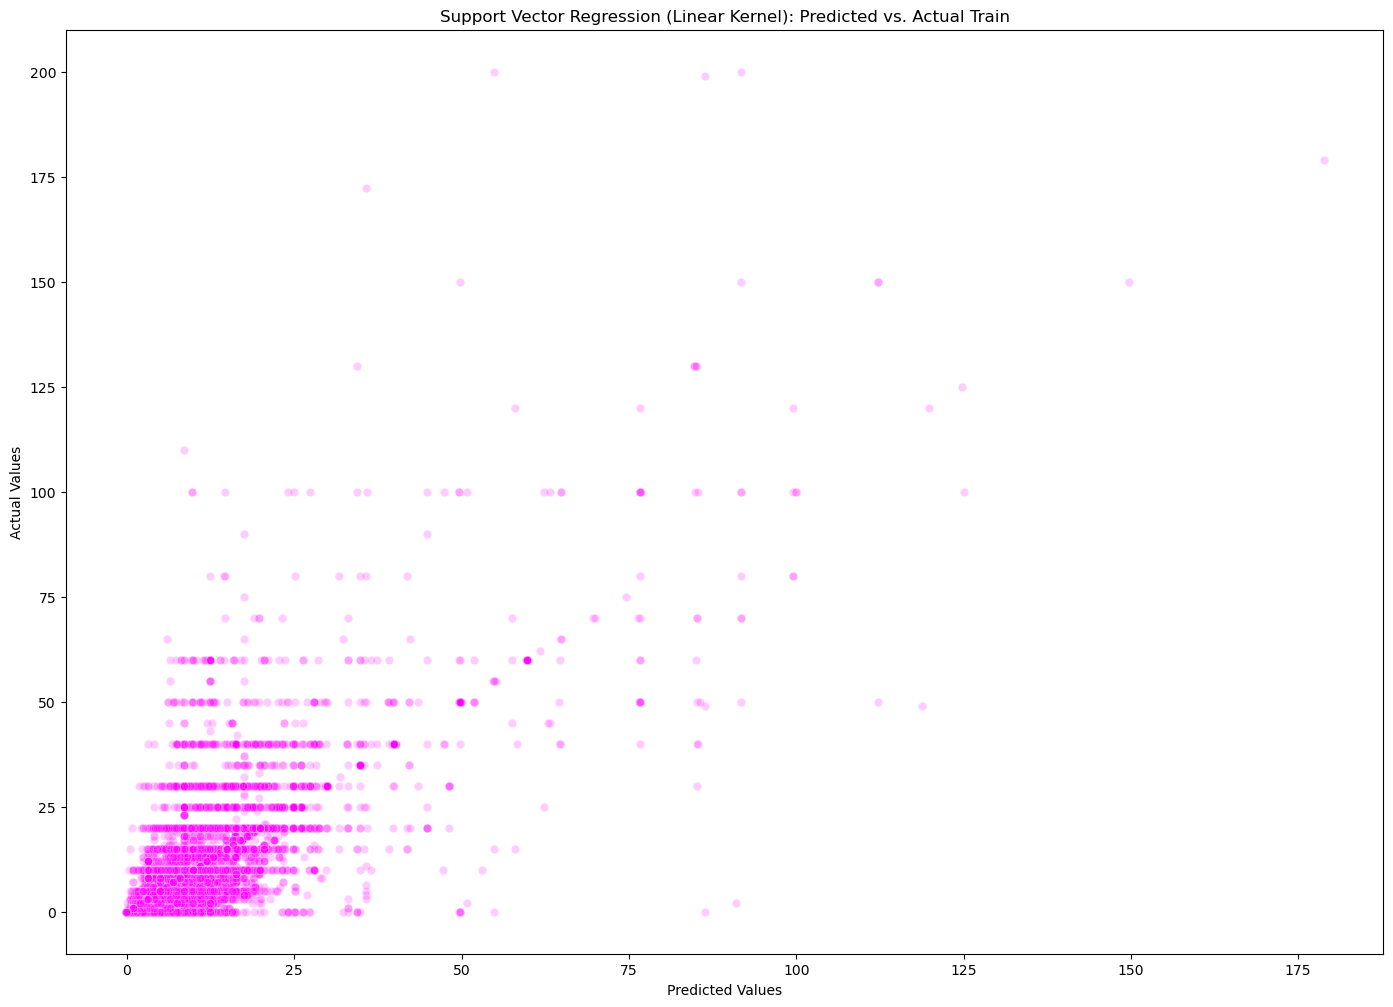

In [48]:
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_train_pred_vector_linear, y=y_train, color='magenta', alpha=0.2)
plt.title('Support Vector Regression (Linear Kernel): Predicted vs. Actual Train')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

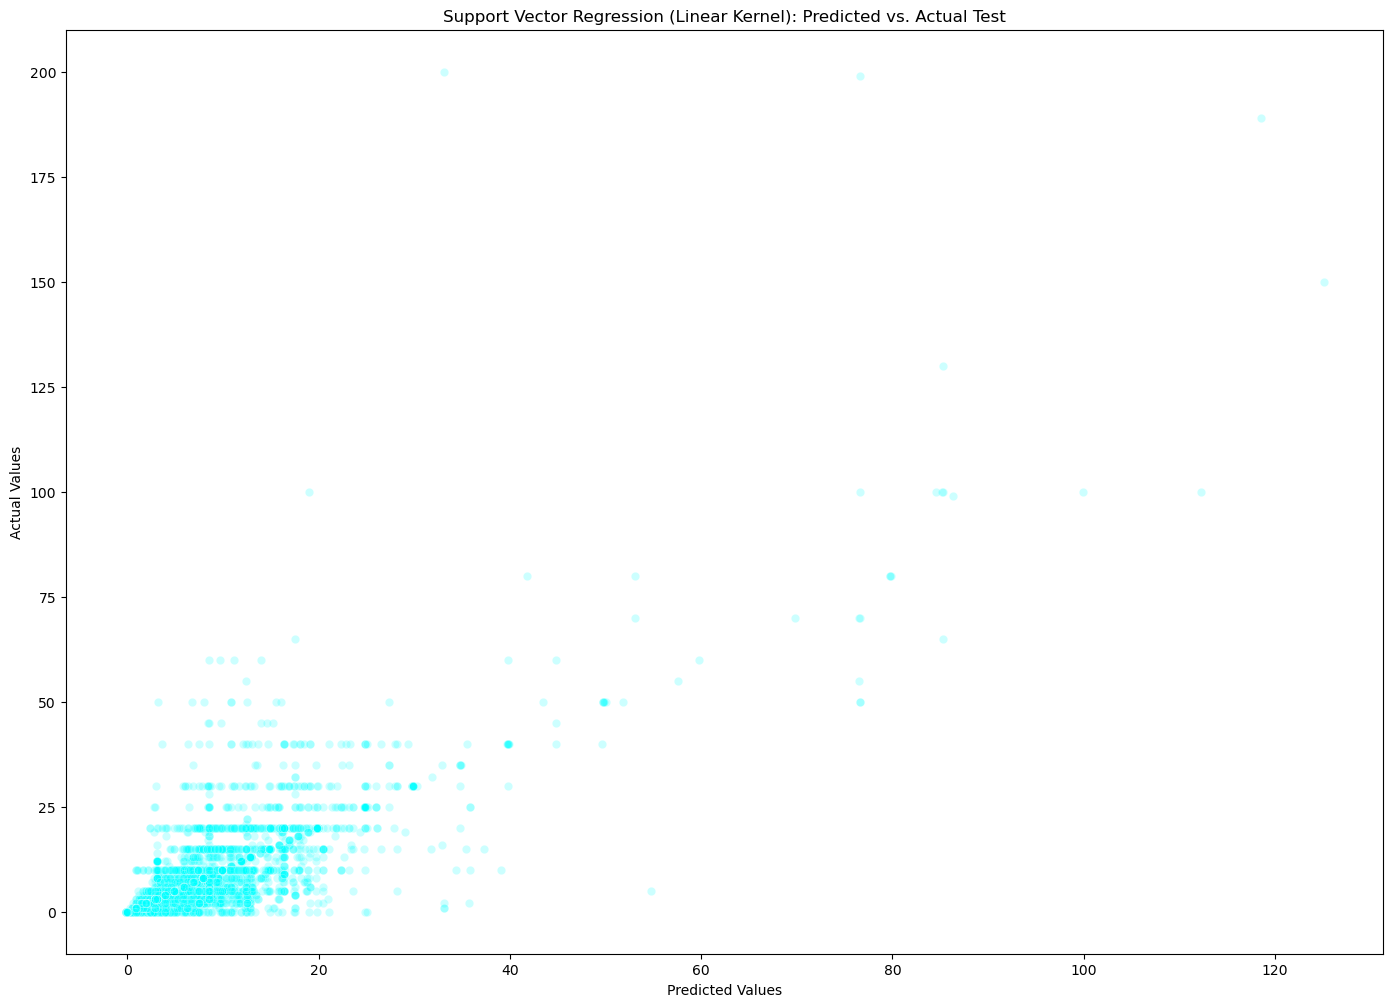

In [49]:
plt.figure(figsize=(17, 12))
sns.scatterplot(x=y_test_pred_vector_linear, y=y_test, color='cyan', alpha=0.2)
plt.title('Support Vector Regression (Linear Kernel): Predicted vs. Actual Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

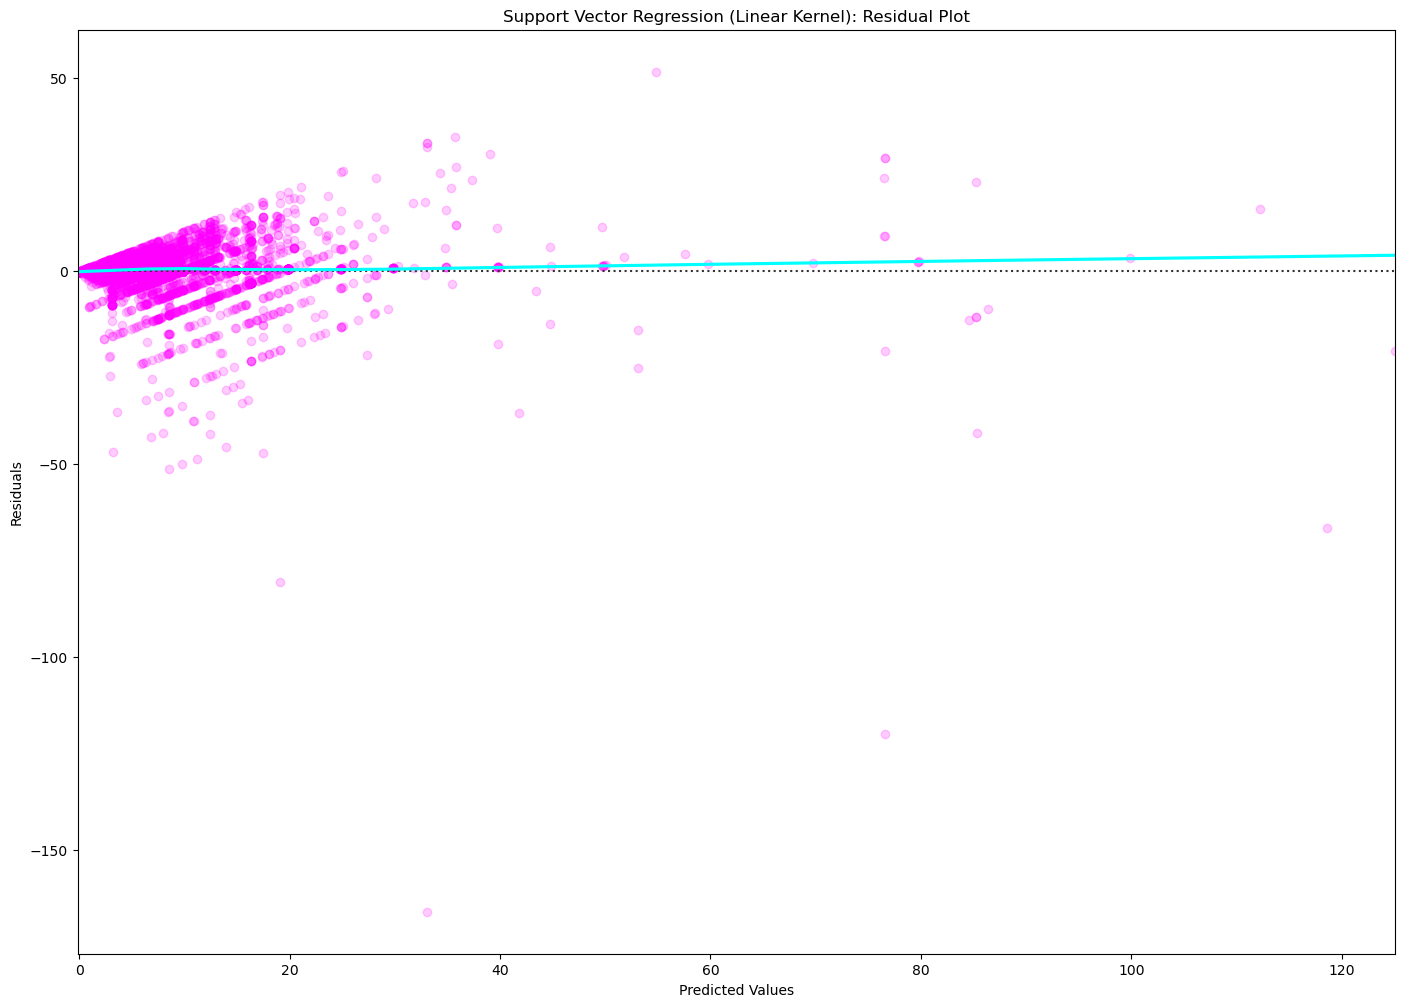

In [50]:
plt.figure(figsize=(17, 12))
sns.residplot(x=y_test_pred_vector_linear, y=y_test_pred_vector_linear - y_test, lowess=True, color='magenta',
              scatter_kws={'alpha': 0.2}, line_kws={'color': 'cyan'})
plt.title('Support Vector Regression (Linear Kernel): Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Probamos la variante polinomial

In [51]:
vector_poly = SupportVectorRegressor(kernel='poly', C=0.1, epsilon=0.1)

vector_poly.fit(X_train, y_train)

SVR(C=0.1, kernel='poly')

In [52]:
y_train_pred_vector_poly = vector_poly.predict(X_train)
y_test_pred_vector_poly = vector_poly.predict(X_test)

mse_train_vector_poly = mean_squared_error(y_train, y_train_pred_vector_poly, squared = True)
mse_test_vector_poly = mean_squared_error(y_test, y_test_pred_vector_poly, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_vector_poly}')
print(f'El error cuadrático medio en Test: {mse_test_vector_poly}')
print()
rmse_train_vector_poly = np.sqrt(mse_train_vector_poly)
rmse_test_vector_poly = np.sqrt(mse_test_vector_poly)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_vector_poly}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_vector_poly}')
print()
r2_vector_poly = r2_score(y_test, y_test_pred_vector_poly)
print('El coeficiente de determinación del regresor es:', r2_vector_poly)

El error cuadrático medio en Train: 66.42843296744805
El error cuadrático medio en Test: 63.98930983108286

Raíz del error cuadrático medio en Train: 8.15036397760542
Raíz del error cuadrático medio en Test: 7.999331836540028

El coeficiente de determinación del regresor es: 0.4196680893083029


Probamos con radial basis function

In [53]:
vector_rbf = SupportVectorRegressor(kernel='rbf', C=0.1, epsilon=0.1)

vector_rbf.fit(X_train, y_train)

SVR(C=0.1)

In [54]:
y_train_pred_vector_rbf = vector_rbf.predict(X_train)
y_test_pred_vector_rbf = vector_rbf.predict(X_test)

mse_train_vector_rbf = mean_squared_error(y_train, y_train_pred_vector_rbf, squared = True)
mse_test_vector_rbf = mean_squared_error(y_test, y_test_pred_vector_rbf, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_vector_rbf}')
print(f'El error cuadrático medio en Test: {mse_test_vector_rbf}')
print()
rmse_train_vector_rbf = np.sqrt(mse_train_vector_rbf)
rmse_test_vector_rbf = np.sqrt(mse_test_vector_rbf)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_vector_rbf}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_vector_rbf}')
print()
r2_vector_rbf = r2_score(y_test, y_test_pred_vector_rbf)
print('El coeficiente de determinación del regresor es:', r2_vector_rbf)

El error cuadrático medio en Train: 76.42669341568889
El error cuadrático medio en Test: 79.44166895391487

Raíz del error cuadrático medio en Train: 8.74223617935874
Raíz del error cuadrático medio en Test: 8.913005607196423

El coeficiente de determinación del regresor es: 0.2795275389863896


## Ensamble: Stacking con 3 modelos de mejor performance

In [55]:
# Elegí los 3 modelos con menor error
estimator_list = [
    ('lineal', lineal),
    ('lineal_poly',lineal_poly),
    ('vector_lineal',vector_linear)]

# Aplico el stacking con el meta modelo lineal
stack_model = StackingRegressor(
    estimators=estimator_list, final_estimator=LinearRegression())

stack_model.fit(X_train, y_train)

y_train_pred_stack = stack_model.predict(X_train)
y_test_pred_stack = stack_model.predict(X_test)

mse_train_stack = mean_squared_error(y_train, y_train_pred_stack, squared = True)
mse_test_stack = mean_squared_error(y_test, y_test_pred_stack, squared = True)
print(f'El error cuadrático medio en Train: {mse_train_stack}')
print(f'El error cuadrático medio en Test: {mse_test_stack}')

print()
rmse_train_stack = np.sqrt(mse_train_stack)
rmse_test_stack = np.sqrt(mse_test_stack)
print(f'Raíz del error cuadrático medio en Train: {rmse_train_stack}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test_stack}')
print()
r2_stack = r2_score(y_test, y_test_pred_stack)
print('El coeficiente de determinación del regresor es:', r2_stack)

El error cuadrático medio en Train: 46.02625012083774
El error cuadrático medio en Test: 41.2400348953122

Raíz del error cuadrático medio en Train: 6.784264891706229
Raíz del error cuadrático medio en Test: 6.421840460126069

El coeficiente de determinación del regresor es: 0.6259858355877538


In [56]:
scores = cross_val_score(stack_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())

Cross-Validation Scores: [51.91931409 49.82885928 38.53471785 48.73956066 42.2973667 ]
Average MSE: 46.26396371396528


In [57]:
scores = cross_val_score(stack_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')

positive_scores = -scores

print("Cross-Validation Scores:", positive_scores)
print("Average MSE:", positive_scores.mean())

Cross-Validation Scores: [36.9686227  59.4110758  41.35942121 39.58752008 30.97723878]
Average MSE: 41.660775715143195


## Pruebas de predicciones y procesamiento de input

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27561 entries, 0 to 27560
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   release_date           27561 non-null  datetime64[ns]
 1   price                  27561 non-null  float64       
 2   developer              27561 non-null  string        
 3   release_age_months     27561 non-null  Int64         
 4   developer_total        27561 non-null  float64       
 5   avg_dev                27561 non-null  float64       
 6   Accounting             27561 non-null  float64       
 7   Action                 27561 non-null  float64       
 8   Adventure              27561 non-null  float64       
 9   Animation & Modeling   27561 non-null  float64       
 10  Audio Production       27561 non-null  float64       
 11  Casual                 27561 non-null  float64       
 12  Design & Illustration  27561 non-null  float64       
 13  E

Recopilamos los nombres de los géneros, y armamos un diccionario, iniciando los valores en 0

In [59]:
df_columns = df.columns[6:26]
column_dict = {col: 0 for col in df_columns}

Simulamos un input un usuario de nuestra API de predicción

In [60]:
genres = ['AdVenTure', 'AcTiON']

Asignamos 1 como valor a los géneros presentes en la lista, case insensitively (sin importar qué combinación de mayúsculas y minúsculas se haya usado en el input)

In [61]:
for genre in genres:
    if genre.lower().capitalize() in column_dict:
        column_dict[genre.lower().capitalize()] = 1

Observamos el resultado

In [62]:
column_dict

{'Accounting': 0,
 'Action': 1,
 'Adventure': 1,
 'Animation & Modeling': 0,
 'Audio Production': 0,
 'Casual': 0,
 'Design & Illustration': 0,
 'Education': 0,
 'Indie': 0,
 'Massively Multiplayer': 0,
 'Photo Editing': 0,
 'RPG': 0,
 'Racing': 0,
 'Simulation': 0,
 'Software Training': 0,
 'Sports': 0,
 'Strategy': 0,
 'Utilities': 0,
 'Video Production': 0,
 'Web Publishing': 0}

Simulamos un input de fecha, en formato YYYY-MM-DD string

In [63]:
release_date = "2012-09-07"
type(release_date)

str

Usamos pandas para que coincida el tipo con el que está en el dataframe

In [64]:
release_date = pd.to_datetime(release_date)
type(release_date)

pandas._libs.tslibs.timestamps.Timestamp

Calculamos la fecha máxima del dataframe

In [65]:
max_date = df['release_date'].max()
print(max_date)
type(max_date)

2018-12-31 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

Calculamos el delta entre la fecha máxima y la ingresada y redondeamos a entero, obteniendo la edad del release en meses

In [66]:
release_age_months = (max_date - release_date) // pd.Timedelta(days=30)

In [67]:
release_age_months

76

Simulamos un input de developer

In [68]:
developer = 'Rocksteady Studios,Feral Interactive (Mac)'

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27561 entries, 0 to 27560
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   release_age_months     27561 non-null  Int64  
 1   developer_total        27561 non-null  float64
 2   avg_dev                27561 non-null  float64
 3   Accounting             27561 non-null  float64
 4   Action                 27561 non-null  float64
 5   Adventure              27561 non-null  float64
 6   Animation & Modeling   27561 non-null  float64
 7   Audio Production       27561 non-null  float64
 8   Casual                 27561 non-null  float64
 9   Design & Illustration  27561 non-null  float64
 10  Education              27561 non-null  float64
 11  Indie                  27561 non-null  float64
 12  Massively Multiplayer  27561 non-null  float64
 13  Photo Editing          27561 non-null  float64
 14  RPG                    27561 non-null  float64
 15  Ra

Obtenemos, según el input de developer, los valores developer_total y avg_dev

In [70]:
specific_developer_rows = df[df['developer'] == developer]

developer_total = specific_developer_rows['developer_total'].iloc[0]
avg_dev = specific_developer_rows['avg_dev'].iloc[0]

print(developer_total, avg_dev)

3.0 19.99


Armamos una primer lista

In [71]:
lista_1 = [release_age_months, developer_total, avg_dev]

Segunda lista, con los valores del diccionario de géneros convertidos a lista (respetando el orden original del dataframe y modelo)

In [72]:
lista_2 = list(column_dict.values())

Convertimos las listas en numpy arrays/vectores

In [73]:
array1 = np.array(lista_1)
array2 = np.array(lista_2)

Concatenamos las listas para obtener la X para las predicciones

In [74]:
X_new = np.concatenate((array1, array2))

Aplicamos el mismo escalado que tiene el modelo

In [75]:
X_new_scaled = sc_X.transform([X_new])

Aplicamos las características polinómicas para el modelo que las utiliza

In [76]:
X_new_poly = poly.transform([X_new])
X_new_poly_scaled = scaler.transform(X_new_poly)

Usamos el modelo de Árbol

In [77]:
chosen_model = tree

Predecimos

In [78]:
y_pred = chosen_model.predict(X_new_scaled)
y_pred[0]

20.553542483659946

Modelo de Ensamble Stacked

In [79]:
chosen_model = stack_model

In [80]:
y_pred = chosen_model.predict(X_new_scaled)
y_pred[0]

19.930499103660125

Usamos el modelo con características polinomiales (y usamos la X acondicionada para este)

In [81]:
chosen_model = lineal_poly

Predecimos

In [82]:
y_pred = chosen_model.predict(X_new_poly_scaled)
y_pred[0]

20.007806277074103

Tomamos el modelo SVR con kernel lineal

In [83]:
chosen_model = vector_linear

Predecimos

In [84]:
y_pred = chosen_model.predict(X_new_scaled)
y_pred[0]

19.865171695416933

Usamos el modelo clásico lineal

In [85]:
chosen_model = lineal

Predecimos

In [86]:
y_pred = chosen_model.predict(X_new_scaled)
y_pred[0]

19.996458405298597

Guardamos los pre procesamientos en un diccionario

In [87]:
preprocessing_steps = {
    'scaler': sc_X
}

Los almacenamos en un archivo de pickle para posterior uso

In [88]:
with open('preprocessing_steps.pkl', 'wb') as file:
    pickle.dump(preprocessing_steps, file)

Guardamos el RMSE del SVR con kernel lineal en testeo en un archivo

In [89]:
with open('rmse_model.txt', 'w') as file:
    file.write(str(rmse_test_lineal))

Guardamos el modelo elegido en un archivo de pickle.

In [90]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(chosen_model, file)

Todos los modelos con base lineal tuvieron performances similares, por encima de los modelos no basados en el lineal. Por simplicidad del modelo, y un menor peso de archivo, elegimos el modelo clásico lineal.

Probamos los archivos

In [91]:
with open('trained_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [92]:
y_pred_loaded = loaded_model.predict(X_new_scaled)

In [93]:
y_pred_loaded[0]

19.996458405298597

In [94]:
with open('rmse_model.txt', 'r') as file:
    rmse_retrieved = file.read()

In [95]:
float(rmse_retrieved)

6.433470063576117